In [1]:
import sys, os
import argparse
import re
import time
# from Deconvolution.BLADE import Framework
import numpy as np
from numpy import transpose as t
import itertools
import pickle
from matplotlib.colors import LogNorm
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error 
import pandas as pd
from tqdm import trange,tqdm
# modules for visualization
import qgrid
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
import cycler
from sklearn.metrics import r2_score
from matplotlib.ticker import FormatStrFormatter
from sklearn.preprocessing import MinMaxScaler
import imblearn

from skbio.stats.composition import ilr,clr,ancom
from skbio import TreeNode
from skbio.stats.ordination import pcoa
import scipy.spatial.distance

import importlib
import warnings
warnings.filterwarnings("ignore")

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
from sccoda.model import other_models as om

import sccoda.datasets as scd

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

2022-08-15 20:46:40.247016: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-15 20:46:40.247049: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Read in cell type compositions from best deconvolution and fga information
- read in BayesPrism top 100DEGs deconvolution cell type fractions
- read in fga data table extracted from Kari's plots

In [2]:
# read in best decon cell type frac results file
# BayesPrism top100DEGs
res_prevail = pd.read_csv("/home/cke/Real/TCGAResults/BayesPrism/celltypefrac_BP_fullpipeline_real_Jul28_real_top100DEGs.csv",index_col=0)
res_prevail['sample'] = res_prevail.index.tolist()
res_prevail['sample'] = res_prevail['sample'].str.rstrip('A')
res_prevail

B-cell     Dendritic  Endothelial  Fibroblast  \
TCGA-BB-4224-01A  2.411960e-06  8.428294e-06     0.021554    0.025049   
TCGA-H7-7774-01A  2.946835e-04  7.654396e-05     0.014944    0.006623   
TCGA-CV-6943-01A  3.293064e-03  1.011790e-03     0.035880    0.382291   
TCGA-CN-5374-01A  5.709435e-03  3.259289e-03     0.037323    0.027008   
TCGA-CQ-6227-01A  1.749130e-06  8.105416e-07     0.090115    0.223870   
...                        ...           ...          ...         ...   
TCGA-CV-7235-01A  2.447322e-07  5.819924e-06     0.046802    0.340756   
TCGA-CX-7086-01A  1.076841e-03  1.317807e-04     0.031584    0.020308   
TCGA-CV-6935-11A  1.406815e-04  1.252411e-06     0.025322    0.012222   
TCGA-P3-A6SW-01A  2.015405e-02  1.773918e-03     0.049495    0.094740   
TCGA-HD-A6HZ-01A  7.891968e-03  6.893420e-03     0.060843    0.114456   

                  Macrophage      Mast       myocyte         other    T-cell  \
TCGA-BB-4224-01A    0.027368  0.000282  8.261100e-03  2.307278e-05  0.005746   
TCGA-H7-7774-01A    0.025805  0.001518  2.656234e-05  2.832948e-03  0.005875   
TCGA-CV-6943-01A    0.135420  0.000807  4.207604e-04  3.151934e-07  0.010174   
TCGA-CN-5374-01A    0.052619  0.000677  1.216315e-02  2.098187e-06  0.028711   
TCGA-CQ-6227-01A    0.017085  0.000501  1.159842e-01  1.288752e-06  0.003212   
...                      ...       ...           ...           ...       ...   
TCGA-CV-7235-01A    0.052835  0.000410  2.725393e-07  5.001734e-07  0.007906   
TCGA-CX-7086-01A    0.012922  0.000071  3.760127e-04  3.780077e-04  0.006510   
TCGA-CV-6935-11A    0.019459  0.000512  1.774254e-05  8.328643e-02  0.001632   
TCGA-P3-A6SW-01A    0.074611  0.003291  9.269963e-05  2.502143e-06  0.022013   
TCGA-HD-A6HZ-01A    0.074855  0.000914  5.875009e-02  4.273614e-06  0.012290   

                     tumor           sample  
TCGA-BB-4224-01A  0.911705  TCGA-BB-4224-01  
TCGA-H7-7774-01A  0.942004  TCGA-H7-7774-01  
TCGA-CV-6943-01A  0.430702  TCGA-CV-6943-01  
TCGA-CN-5374-01A  0.832527  TCGA-CN-5374-01  
TCGA-CQ-6227-01A  0.549231  TCGA-CQ-6227-01  
...                    ...              ...  
TCGA-CV-7235-01A  0.551284  TCGA-CV-7235-01  
TCGA-CX-7086-01A  0.926642  TCGA-CX-7086-01  
TCGA-CV-6935-11A  0.857408  TCGA-CV-6935-11  
TCGA-P3-A6SW-01A  0.733826  TCGA-P3-A6SW-01  
TCGA-HD-A6HZ-01A  0.663102  TCGA-HD-A6HZ-01  

[546 rows x 11 columns]

In [3]:
# read in best decon cell type frac results file
# BayesPrism top100DEGs
res_prevail_subtypes = pd.read_csv("/home/cke/Real/TCGAResults/BayesPrism/celltypefrac_BP_ImmuneSubtypes_real_top100DEGs_Aug8.csv",index_col=0)
res_prevail_subtypes['sample'] = res_prevail_subtypes.index.tolist()
res_prevail_subtypes['sample'] = res_prevail_subtypes['sample'].str.rstrip('A')
res_prevail_subtypes

B-cells  CD14-cells  CD8-cells  Endothelial  \
TCGA-BB-4224-01A  7.521237e-07    0.000029   0.005354     0.018995   
TCGA-H7-7774-01A  2.474022e-04    0.000016   0.006565     0.012817   
TCGA-CV-6943-01A  3.798463e-03    0.000004   0.016057     0.038715   
TCGA-CN-5374-01A  5.620612e-03    0.002204   0.014791     0.037763   
TCGA-CQ-6227-01A  2.847449e-07    0.000001   0.000001     0.088822   
...                        ...         ...        ...          ...   
TCGA-CV-7235-01A  3.909553e-07    0.000652   0.011922     0.051758   
TCGA-CX-7086-01A  1.092963e-03    0.000544   0.005968     0.032534   
TCGA-CV-6935-11A  3.001992e-04    0.000001   0.001230     0.027298   
TCGA-P3-A6SW-01A  2.081898e-02    0.001012   0.017182     0.050244   
TCGA-HD-A6HZ-01A  8.469815e-03    0.010019   0.004468     0.061878   

                  Fibroblast  Macrophage          Mast      NK-cells  \
TCGA-BB-4224-01A    0.019089    0.016671  1.783831e-04  4.943720e-03   
TCGA-H7-7774-01A    0.000524    0.017262  5.097020e-04  3.108857e-05   
TCGA-CV-6943-01A    0.380978    0.132247  7.728221e-04  7.299435e-07   
TCGA-CN-5374-01A    0.022564    0.042804  5.407611e-04  3.753455e-03   
TCGA-CQ-6227-01A    0.241242    0.002588  5.012126e-07  4.404987e-06   
...                      ...         ...           ...           ...   
TCGA-CV-7235-01A    0.331036    0.043414  3.739575e-04  1.721061e-03   
TCGA-CX-7086-01A    0.013663    0.005613  6.030335e-05  2.351940e-03   
TCGA-CV-6935-11A    0.009082    0.037307  4.052511e-04  5.923958e-04   
TCGA-P3-A6SW-01A    0.087746    0.048346  2.908469e-03  9.189827e-06   
TCGA-HD-A6HZ-01A    0.117164    0.050565  3.987480e-04  6.222276e-03   

                  pDC-cells    Tconv-cell    Treg-cells     tumor  \
TCGA-BB-4224-01A   0.001033  6.065475e-03  3.046525e-04  0.927337   
TCGA-H7-7774-01A   0.001078  5.746715e-07  7.144899e-04  0.960234   
TCGA-CV-6943-01A   0.002719  2.688987e-07  1.883073e-03  0.422823   
TCGA-CN-5374-01A   0.006411  1.306061e-02  2.010434e-02  0.830384   
TCGA-CQ-6227-01A   0.000002  1.263138e-01  8.880127e-07  0.541024   
...                     ...           ...           ...       ...   
TCGA-CV-7235-01A   0.000740  2.944636e-07  1.210964e-03  0.557172   
TCGA-CX-7086-01A   0.002253  1.266288e-06  1.168945e-05  0.935906   
TCGA-CV-6935-11A   0.000022  6.677475e-04  2.754238e-04  0.922819   
TCGA-P3-A6SW-01A   0.013509  7.265310e-07  1.708835e-02  0.741135   
TCGA-HD-A6HZ-01A   0.002939  6.468833e-02  7.463512e-03  0.665725   

                           sample  
TCGA-BB-4224-01A  TCGA-BB-4224-01  
TCGA-H7-7774-01A  TCGA-H7-7774-01  
TCGA-CV-6943-01A  TCGA-CV-6943-01  
TCGA-CN-5374-01A  TCGA-CN-5374-01  
TCGA-CQ-6227-01A  TCGA-CQ-6227-01  
...                           ...  
TCGA-CV-7235-01A  TCGA-CV-7235-01  
TCGA-CX-7086-01A  TCGA-CX-7086-01  
TCGA-CV-6935-11A  TCGA-CV-6935-11  
TCGA-P3-A6SW-01A  TCGA-P3-A6SW-01  
TCGA-HD-A6HZ-01A  TCGA-HD-A6HZ-01  

[546 rows x 13 columns]

In [4]:
# read in fga data table from Kari's plots
fga_Kari = pd.read_csv("/home/cke/KariPDF/fga_table.csv",header=None)
fga_Kari.columns = ['sample','fga']
fga_Kari

sample    fga
0    TCGA-CR-7391-01  0.617
1    TCGA-CN-6995-01  0.712
2    TCGA-CQ-A4C6-01  0.354
3    TCGA-CV-A6K0-01  0.676
4    TCGA-CR-6471-01  0.134
..               ...    ...
519  TCGA-CN-4725-01  0.576
520  TCGA-CV-7440-01  0.635
521  TCGA-CN-4726-01  0.298
522  TCGA-CN-A6V6-01  0.442
523  TCGA-CR-6467-01  0.476

[524 rows x 2 columns]

In [5]:
# using cellularity extracted from Kari's plots pdf 
cellularity_Kari = pd.read_csv("/home/cke/KariPDF/cellularity_table.csv",header=None)
cellularity_Kari.columns = ['sample','cellularity']
cellularity_Kari = cellularity_Kari[cellularity_Kari['cellularity']<1.0]
# cellularity_Kari

In [6]:
df_merged = pd.merge(res_prevail,pd.merge(cellularity_Kari,fga_Kari,on='sample'))
# Merging fga + cell type fractions 

In [7]:
df_merged_subtypes = pd.merge(res_prevail_subtypes,pd.merge(cellularity_Kari,fga_Kari,on='sample'))

### Merge fga + cell type fractions and add FGA status with cutoff 0.2

In [8]:
def define_FGA(fga):
    if fga > 0.2:
        return 'High'
    else:
        return 'Silent'
df_merged['FGA_status'] = df_merged['fga'].apply(define_FGA)
df_merged_subtypes['FGA_status'] = df_merged_subtypes['fga'].apply(define_FGA)

In [9]:
df_merged

B-cell     Dendritic  Endothelial  Fibroblast  Macrophage  \
0    2.411960e-06  8.428294e-06     0.021554    0.025049    0.027368   
1    2.946835e-04  7.654396e-05     0.014944    0.006623    0.025805   
2    3.293064e-03  1.011790e-03     0.035880    0.382291    0.135420   
3    5.709435e-03  3.259289e-03     0.037323    0.027008    0.052619   
4    1.749130e-06  8.105416e-07     0.090115    0.223870    0.017085   
..            ...           ...          ...         ...         ...   
479  6.054611e-03  1.846723e-06     0.062586    0.095856    0.043977   
480  2.447322e-07  5.819924e-06     0.046802    0.340756    0.052835   
481  1.076841e-03  1.317807e-04     0.031584    0.020308    0.012922   
482  2.015405e-02  1.773918e-03     0.049495    0.094740    0.074611   
483  7.891968e-03  6.893420e-03     0.060843    0.114456    0.074855   

         Mast       myocyte         other    T-cell     tumor  \
0    0.000282  8.261100e-03  2.307278e-05  0.005746  0.911705   
1    0.001518  2.656234e-05  2.832948e-03  0.005875  0.942004   
2    0.000807  4.207604e-04  3.151934e-07  0.010174  0.430702   
3    0.000677  1.216315e-02  2.098187e-06  0.028711  0.832527   
4    0.000501  1.159842e-01  1.288752e-06  0.003212  0.549231   
..        ...           ...           ...       ...       ...   
479  0.000638  5.265638e-04  1.956283e-01  0.000798  0.593934   
480  0.000410  2.725393e-07  5.001734e-07  0.007906  0.551284   
481  0.000071  3.760127e-04  3.780077e-04  0.006510  0.926642   
482  0.003291  9.269963e-05  2.502143e-06  0.022013  0.733826   
483  0.000914  5.875009e-02  4.273614e-06  0.012290  0.663102   

              sample  cellularity    fga FGA_status  
0    TCGA-BB-4224-01         0.59  0.526       High  
1    TCGA-H7-7774-01         0.48  0.169     Silent  
2    TCGA-CV-6943-01         0.19  0.170     Silent  
3    TCGA-CN-5374-01         0.36  0.572       High  
4    TCGA-CQ-6227-01         0.26  0.650       High  
..               ...          ...    ...        ...  
479  TCGA-CN-6010-01         0.36  0.736       High  
480  TCGA-CV-7235-01         0.40  0.778       High  
481  TCGA-CX-7086-01         0.61  0.642       High  
482  TCGA-P3-A6SW-01         0.28  0.545       High  
483  TCGA-HD-A6HZ-01         0.31  0.603       High  

[484 rows x 14 columns]

### Get concensus HPV positive sample annotations from Nulton et al. 2017 and official TCGA GDC phenodata

In [10]:
Nulton = pd.read_excel("/home/cke/Nulton 2017 - supplementary.xlsx",sheet_name=1)
Nulton

HNSCC Barcode   Type
0   TCGA-HD-A634  HPV16
1   TCGA-P3-A5QE  HPV16
2   TCGA-BA-A4IH  HPV16
3   TCGA-BB-7866  HPV16
4   TCGA-DQ-7596  HPV16
..           ...    ...
67  TCGA-CV-6939  HPV33
68  TCGA-DQ-7591  HPV35
69  TCGA-IQ-A61I  HPV35
70  TCGA-HD-8314  HPV35
71  TCGA-BB-7864  HPV56

[72 rows x 2 columns]

In [11]:
TCGA_pheno = pd.read_csv("/home/cke/TCGA-HNSC.GDC_phenotype.tsv",sep='\t')
TCGA_pheno['hpv_status']=''
TCGA_pheno.loc[(TCGA_pheno['hpv_status_by_ish_testing']=='Positive') | (TCGA_pheno['hpv_status_by_p16_testing']=='Positive'),'hpv_status']='Positive'
TCGA_pheno.loc[(TCGA_pheno['hpv_status_by_ish_testing']=='Negative') & (TCGA_pheno['hpv_status_by_p16_testing']=='Negative'),'hpv_status']='Negative'
TCGA_pheno['hpv_status'].value_counts()

            510
Negative     57
Positive     45
Name: hpv_status, dtype: int64

In [12]:
TCGA_pheno.columns.tolist()

['submitter_id.samples',
 'additional_pharmaceutical_therapy',
 'additional_radiation_therapy',
 'additional_surgery_locoregional_procedure',
 'additional_surgery_metastatic_procedure',
 'age_at_initial_pathologic_diagnosis',
 'amount_of_alcohol_consumption_per_day',
 'batch_number',
 'bcr',
 'bcr_followup_barcode',
 'bcr_followup_uuid',
 'submitter_id',
 'clinical_M',
 'clinical_N',
 'clinical_T',
 'clinical_stage',
 'day_of_dcc_upload',
 'day_of_form_completion',
 'days_to_additional_surgery_locoregional_procedure',
 'days_to_additional_surgery_metastatic_procedure',
 'days_to_completion_of_curative_tx',
 'days_to_initial_pathologic_diagnosis',
 'days_to_new_tumor_event_after_initial_treatment',
 'disease_after_curative_tx',
 'egfr_amplication_status',
 'file_uuid',
 'followup_case_report_form_submission_reason',
 'followup_treatment_success',
 'frequency_of_alcohol_consumption',
 'history_of_neoadjuvant_treatment',
 'hpv_status_by_ish_testing',
 'hpv_status_by_p16_testing',
 'inform

In [13]:
TCGA_pheno['sample'] = TCGA_pheno['submitter_id.samples'].str.rsplit("-",n=1,expand=True)[0]

In [14]:
list_pos_tcgaPheno = TCGA_pheno[TCGA_pheno['hpv_status']=='Positive']['sample'].tolist()
list_pos_Nulton = Nulton['HNSCC Barcode'].tolist()

In [15]:
# remove conflict samples between TCGA annotation and Nulton et al.
list_remove = []
for i in list_pos_tcgaPheno:
    if i not in list_pos_Nulton:
        list_remove.append(i)
list_remove

['TCGA-CN-A640',
 'TCGA-CN-A641',
 'TCGA-QK-A8ZA',
 'TCGA-DQ-7595',
 'TCGA-QK-AA3K',
 'TCGA-BB-7872',
 'TCGA-BA-A6DA',
 'TCGA-CN-A63Y',
 'TCGA-BA-A6DF',
 'TCGA-CN-A6V1']

In [16]:
set_pos = list_pos_Nulton
print("We gathered",len(list_pos_Nulton),"Positive samples from two source") 
print("We removed",len(list_remove),"conflicting samples") 

We gathered 72 Positive samples from two source
We removed 10 conflicting samples


## Read in anatomical sites and sample type data 

In [17]:
TCGA_pheno['sample_type.samples'].value_counts()
# Select only primary tumor

Primary Tumor          528
Solid Tissue Normal     82
Metastatic               2
Name: sample_type.samples, dtype: int64

In [18]:
# All TCGA annotated primary sites, merge to 4 major sites
TCGA_pheno['primary_site'].value_counts()

Other and unspecified parts of tongue                                   158
Larynx                                                                  144
Other and ill-defined sites in lip, oral cavity and pharynx              90
Floor of mouth                                                           62
Tonsil                                                                   47
Other and unspecified parts of mouth                                     44
Base of tongue                                                           27
Gum                                                                      11
Oropharynx                                                               10
Hypopharynx                                                               9
Palate                                                                    6
Lip                                                                       3
Bones, joints and articular cartilage of other and unspecified sites      1
Name: primar

In [19]:
dict_primary_site = {'Alveolar Ridge': 'Oral Cavity',
 'Floor of mouth': 'Oral Cavity',
 'Palate': 'Oral Cavity',
 'Lip': 'Oral Cavity',
 'Oral Tongue': 'Oral Cavity',
 'Oral Cavity': 'Oral Cavity',
 'Other and unspecified parts of tongue': 'Oral Cavity',
 'Other and unspecified parts of mouth': 'Oral Cavity',
 'Base of tongue': 'Oropharynx',
 'Tonsil': 'Oropharynx',
 'Oropharynx': 'Oropharynx',
    'Larynx': 'Larynx',    
    'Floor of mouth':'Oral Cavity',
    'Gum':'Oral Cavity',
    'Oropharynx':'Oropharynx',
    'Hypopharynx':'Hypopharynx',}

In [20]:
TCGA_pheno_new = TCGA_pheno.copy()
TCGA_pheno_new['primary_site'] = TCGA_pheno_new['primary_site'].map(dict_primary_site)
TCGA_pheno_new.dropna(subset='primary_site',inplace=True)

#Selecting only primary tumor!
TCGA_pheno_new = TCGA_pheno_new[TCGA_pheno_new['sample_type.samples']=='Primary Tumor']
TCGA_pheno_new['primary_site'].value_counts()

Oral Cavity    250
Larynx         117
Oropharynx      80
Hypopharynx      9
Name: primary_site, dtype: int64

In [21]:
df_merged['sample_match'] = df_merged['sample'].str.rsplit("-",n=1,expand=True)[0]

df_merged_sites = pd.merge(df_merged,TCGA_pheno_new[['sample','primary_site']],left_on='sample_match',right_on='sample')
df_merged_sites

B-cell  Dendritic  Endothelial  Fibroblast  Macrophage      Mast  \
0    2.411960e-06   0.000008     0.021554    0.025049    0.027368  0.000282   
1    3.293064e-03   0.001012     0.035880    0.382291    0.135420  0.000807   
2    5.709435e-03   0.003259     0.037323    0.027008    0.052619  0.000677   
3    9.027032e-04   0.000002     0.071847    0.081868    0.050790  0.000264   
4    5.913925e-04   0.000002     0.020984    0.029199    0.007936  0.000043   
..            ...        ...          ...         ...         ...       ...   
409  6.054611e-03   0.000002     0.062586    0.095856    0.043977  0.000638   
410  2.447322e-07   0.000006     0.046802    0.340756    0.052835  0.000410   
411  1.076841e-03   0.000132     0.031584    0.020308    0.012922  0.000071   
412  2.015405e-02   0.001774     0.049495    0.094740    0.074611  0.003291   
413  7.891968e-03   0.006893     0.060843    0.114456    0.074855  0.000914   

          myocyte         other    T-cell     tumor         sample_x  \
0    8.261100e-03  2.307278e-05  0.005746  0.911705  TCGA-BB-4224-01   
1    4.207604e-04  3.151934e-07  0.010174  0.430702  TCGA-CV-6943-01   
2    1.216315e-02  2.098187e-06  0.028711  0.832527  TCGA-CN-5374-01   
3    1.089332e-01  1.467499e-06  0.004751  0.680641  TCGA-CV-6959-01   
4    4.149415e-02  1.773275e-02  0.005312  0.876706  TCGA-F7-A61V-01   
..            ...           ...       ...       ...              ...   
409  5.265638e-04  1.956283e-01  0.000798  0.593934  TCGA-CN-6010-01   
410  2.725393e-07  5.001734e-07  0.007906  0.551284  TCGA-CV-7235-01   
411  3.760127e-04  3.780077e-04  0.006510  0.926642  TCGA-CX-7086-01   
412  9.269963e-05  2.502143e-06  0.022013  0.733826  TCGA-P3-A6SW-01   
413  5.875009e-02  4.273614e-06  0.012290  0.663102  TCGA-HD-A6HZ-01   

     cellularity    fga FGA_status  sample_match      sample_y primary_site  
0           0.59  0.526       High  TCGA-BB-4224  TCGA-BB-4224  Oral Cavity  
1           0.19  0.170     Silent  TCGA-CV-6943  TCGA-CV-6943   Oropharynx  
2           0.36  0.572       High  TCGA-CN-5374  TCGA-CN-5374   Oropharynx  
3           0.36  0.430       High  TCGA-CV-6959  TCGA-CV-6959  Oral Cavity  
4           0.60  0.192     Silent  TCGA-F7-A61V  TCGA-F7-A61V   Oropharynx  
..           ...    ...        ...           ...           ...          ...  
409         0.36  0.736       High  TCGA-CN-6010  TCGA-CN-6010       Larynx  
410         0.40  0.778       High  TCGA-CV-7235  TCGA-CV-7235  Oral Cavity  
411         0.61  0.642       High  TCGA-CX-7086  TCGA-CX-7086  Oral Cavity  
412         0.28  0.545       High  TCGA-P3-A6SW  TCGA-P3-A6SW   Oropharynx  
413         0.31  0.603       High  TCGA-HD-A6HZ  TCGA-HD-A6HZ  Oral Cavity  

[414 rows x 17 columns]

In [22]:
df_merged_subtypes['sample_match'] = df_merged_subtypes['sample'].str.rsplit("-",n=1,expand=True)[0]

df_merged_subtypes_sites = pd.merge(df_merged_subtypes,TCGA_pheno_new[['sample','primary_site']],left_on='sample_match',right_on='sample')
df_merged_subtypes_sites

B-cells  CD14-cells  CD8-cells  Endothelial  Fibroblast  Macrophage  \
0    7.521237e-07    0.000029   0.005354     0.018995    0.019089    0.016671   
1    3.798463e-03    0.000004   0.016057     0.038715    0.380978    0.132247   
2    5.620612e-03    0.002204   0.014791     0.037763    0.022564    0.042804   
3    5.509745e-04    0.000005   0.002348     0.075136    0.086814    0.028031   
4    3.553009e-04    0.000003   0.000567     0.018644    0.023915    0.000003   
..            ...         ...        ...          ...         ...         ...   
409  6.985689e-03    0.000002   0.000021     0.068687    0.092435    0.102898   
410  3.909553e-07    0.000652   0.011922     0.051758    0.331036    0.043414   
411  1.092963e-03    0.000544   0.005968     0.032534    0.013663    0.005613   
412  2.081898e-02    0.001012   0.017182     0.050244    0.087746    0.048346   
413  8.469815e-03    0.010019   0.004468     0.061878    0.117164    0.050565   

             Mast      NK-cells  pDC-cells    Tconv-cell  Treg-cells  \
0    1.783831e-04  4.943720e-03   0.001033  6.065475e-03    0.000305   
1    7.728221e-04  7.299435e-07   0.002719  2.688987e-07    0.001883   
2    5.407611e-04  3.753455e-03   0.006411  1.306061e-02    0.020104   
3    3.417677e-07  3.955105e-03   0.000014  1.119808e-01    0.000006   
4    4.332584e-07  1.042917e-03   0.001550  5.635728e-02    0.002311   
..            ...           ...        ...           ...         ...   
409  8.159275e-04  7.523645e-06   0.000001  1.907857e-02    0.000004   
410  3.739575e-04  1.721061e-03   0.000740  2.944636e-07    0.001211   
411  6.030335e-05  2.351940e-03   0.002253  1.266288e-06    0.000012   
412  2.908469e-03  9.189827e-06   0.013509  7.265310e-07    0.017088   
413  3.987480e-04  6.222276e-03   0.002939  6.468833e-02    0.007464   

        tumor         sample_x  cellularity    fga FGA_status  sample_match  \
0    0.927337  TCGA-BB-4224-01         0.59  0.526       High  TCGA-BB-4224   
1    0.422823  TCGA-CV-6943-01         0.19  0.170     Silent  TCGA-CV-6943   
2    0.830384  TCGA-CN-5374-01         0.36  0.572       High  TCGA-CN-5374   
3    0.691159  TCGA-CV-6959-01         0.36  0.430       High  TCGA-CV-6959   
4    0.895251  TCGA-F7-A61V-01         0.60  0.192     Silent  TCGA-F7-A61V   
..        ...              ...          ...    ...        ...           ...   
409  0.709064  TCGA-CN-6010-01         0.36  0.736       High  TCGA-CN-6010   
410  0.557172  TCGA-CV-7235-01         0.40  0.778       High  TCGA-CV-7235   
411  0.935906  TCGA-CX-7086-01         0.61  0.642       High  TCGA-CX-7086   
412  0.741135  TCGA-P3-A6SW-01         0.28  0.545       High  TCGA-P3-A6SW   
413  0.665725  TCGA-HD-A6HZ-01         0.31  0.603       High  TCGA-HD-A6HZ   

         sample_y primary_site  
0    TCGA-BB-4224  Oral Cavity  
1    TCGA-CV-6943   Oropharynx  
2    TCGA-CN-5374   Oropharynx  
3    TCGA-CV-6959  Oral Cavity  
4    TCGA-F7-A61V   Oropharynx  
..            ...          ...  
409  TCGA-CN-6010       Larynx  
410  TCGA-CV-7235  Oral Cavity  
411  TCGA-CX-7086  Oral Cavity  
412  TCGA-P3-A6SW   Oropharynx  
413  TCGA-HD-A6HZ  Oral Cavity  

[414 rows x 19 columns]

### Create merged data table for HPV pos and neg groups

In [23]:
df_merged_HPVpos = df_merged_sites.copy()
df_merged_HPVpos = df_merged_HPVpos[df_merged_HPVpos['sample_match'].isin(set_pos)]
df_merged_HPVpos['hpv_status'] = "Positive"
# df_merged_HPVpos
print(df_merged_HPVpos.shape[0])

58


In [24]:
df_merged_HPVneg = df_merged_sites.copy()
df_merged_HPVneg = df_merged_HPVneg[~df_merged_HPVneg['sample_match'].isin(set_pos) & ~df_merged_HPVneg['sample_match'].isin(list_remove)]
df_merged_HPVneg['hpv_status'] = "Negative"
# df_merged_HPVneg
print(df_merged_HPVneg.shape[0])

352


In [25]:
df_merged_HPVpos_subtypes = df_merged_subtypes_sites.copy()
df_merged_HPVpos_subtypes = df_merged_HPVpos_subtypes[df_merged_HPVpos_subtypes['sample_match'].isin(set_pos)]
df_merged_HPVpos_subtypes['hpv_status'] = "Positive"
# df_merged_HPVpos
print(df_merged_HPVpos_subtypes.shape[0])

58


In [26]:
df_merged_HPVneg_subtypes = df_merged_subtypes_sites.copy()
df_merged_HPVneg_subtypes = df_merged_HPVneg_subtypes[~df_merged_HPVneg_subtypes['sample_match'].isin(set_pos) & ~df_merged_HPVneg_subtypes['sample_match'].isin(list_remove)]
df_merged_HPVneg_subtypes['hpv_status'] = "Negative"
# df_merged_HPVneg
print(df_merged_HPVneg_subtypes.shape[0])

352


In [27]:
# Ultimate dataframe containing all information
df_merged_nonrelative = pd.concat([df_merged_HPVpos,df_merged_HPVneg])
df_merged_subtypes_nonrelative = pd.concat([df_merged_HPVpos_subtypes,df_merged_HPVneg_subtypes])

## Statistical differential proposrtion analysis (abundance) using Isometric log-ratio transformation
### ANNCOM

A table of features, their W-statistics and whether the null hypothesis is rejected.

“W” is the W-statistic, or number of features that a single feature is tested to be significantly different against.

“reject” indicates if feature is significantly different or not.


In [77]:
ancomres_fga = ancom(df_merged_HPVneg[df_merged_HPVneg['primary_site']=='Oral Cavity'].iloc[:,:10],df_merged_HPVneg[df_merged_HPVneg['primary_site']=='Oral Cavity']['FGA_status'],multiple_comparisons_correction='holm-bonferroni')
ancomres_fga[0]

W  Reject null hypothesis
B-cell       1                   False
Dendritic    4                   False
Endothelial  2                   False
Fibroblast   2                   False
Macrophage   4                   False
Mast         0                   False
myocyte      8                    True
other        0                   False
T-cell       1                   False
tumor        2                   False

In [79]:
ancomres_fga_subtypes = ancom(df_merged_HPVneg_subtypes[df_merged_HPVneg_subtypes['primary_site']=='Oral Cavity'].iloc[:,:12],df_merged_HPVneg_subtypes[df_merged_HPVneg_subtypes['primary_site']=='Oral Cavity']['FGA_status'],multiple_comparisons_correction='holm-bonferroni')
ancomres_fga_subtypes[0]

W  Reject null hypothesis
B-cells      1                   False
CD14-cells   1                   False
CD8-cells    3                   False
Endothelial  1                   False
Fibroblast   3                   False
Macrophage   3                   False
Mast         1                   False
NK-cells     9                    True
pDC-cells    2                   False
Tconv-cell   9                    True
Treg-cells   6                   False
tumor        1                   False

In [78]:
ancomres_sites = ancom(df_merged_HPVneg.iloc[:,:10],df_merged_HPVneg['primary_site'],multiple_comparisons_correction='holm-bonferroni')
ancomres_sites[0]

W  Reject null hypothesis
B-cell       8                    True
Dendritic    3                   False
Endothelial  5                   False
Fibroblast   4                   False
Macrophage   3                   False
Mast         3                   False
myocyte      9                    True
other        8                    True
T-cell       3                   False
tumor        4                   False

In [80]:
ancomres_sites_subtypes = ancom(df_merged_HPVneg_subtypes.iloc[:,:12],df_merged_HPVneg_subtypes['primary_site'],multiple_comparisons_correction='holm-bonferroni')
ancomres_sites_subtypes[0]

W  Reject null hypothesis
B-cells      11                    True
CD14-cells    2                   False
CD8-cells     1                   False
Endothelial   4                   False
Fibroblast    5                   False
Macrophage    2                   False
Mast          3                   False
NK-cells      3                   False
pDC-cells     2                   False
Tconv-cell   11                    True
Treg-cells    2                   False
tumor         5                   False

In [83]:
ancomres_hpv = ancom(df_merged_nonrelative[df_merged_nonrelative['primary_site']=='Oropharynx'].iloc[:,:10],df_merged_nonrelative[df_merged_nonrelative['primary_site']=='Oropharynx']['hpv_status'],multiple_comparisons_correction='holm-bonferroni')
ancomres_hpv[0]

W  Reject null hypothesis
B-cell       9                    True
Dendritic    9                    True
Endothelial  6                   False
Fibroblast   7                   False
Macrophage   5                   False
Mast         4                   False
myocyte      2                   False
other        2                   False
T-cell       5                   False
tumor        6                   False

In [272]:
ancomres_hpv_subtypes = ancom(df_merged_subtypes_nonrelative[df_merged_subtypes_nonrelative['primary_site']=='Oropharynx'].iloc[:,:12],df_merged_subtypes_nonrelative[df_merged_subtypes_nonrelative['primary_site']=='Oropharynx']['hpv_status'],multiple_comparisons_correction='holm-bonferroni')
ancomres_hpv_subtypes[0]

W  Reject null hypothesis
B-cells      4                   False
CD14-cells   9                    True
CD8-cells    5                   False
Endothelial  5                   False
Fibroblast   9                    True
Macrophage   3                   False
Mast         5                   False
NK-cells     3                   False
pDC-cells    8                    True
Tconv-cell   3                   False
Treg-cells   6                   False
tumor        8                    True

### scCODA analysis pipeline
statistical analysis of hpv- oc for CNA subgroups, hpv- for anatomical subsites, Oropharynx for hpv status 

### CLR+T-test

In [351]:
def scCODA_CLRttest_run(df,cols_num=10,condition='FGA_status'):
    list_col_use_coda = df.columns[:cols_num].tolist()
    df.loc[:,list_col_use_coda] = df.loc[:,list_col_use_coda]*100
    list_col_use_coda.append(condition)
    
    data_merged = dat.from_pandas(df.loc[:,list_col_use_coda], covariate_columns=[condition])
    data_merged.obs['sample'] = df['sample_match'].tolist()
#     print(data_merged.X)
    print(data_merged.obs)
    alr_t_model = om.CLRModel_ttest(data_merged, covariate_column=condition)
    alr_t_model.fit_model()
    print(alr_t_model.p_val)
    return alr_t_model

In [315]:
fga_results_ttest = scCODA_CLRttest_run(df_merged_HPVneg[df_merged_HPVneg['primary_site']=='Oral Cavity'],cols_num=10,condition='FGA_status',)

    FGA_status        sample
0         High  TCGA-BB-4224
3         High  TCGA-CV-6959
7         High  TCGA-BB-8601
9       Silent  TCGA-CQ-7063
10        High  TCGA-CN-5373
..         ...           ...
407       High  TCGA-CV-A464
408       High  TCGA-C9-A47Z
410       High  TCGA-CV-7235
411       High  TCGA-CX-7086
413       High  TCGA-HD-A6HZ

[218 rows x 2 columns]
[0.7181319881175856, 0.17109565725611758, 0.6906125131774004, 0.8781350856955366, 0.2659043241400531, 0.22115154124004077, 0.32670538945616034, 0.16076868429062782, 0.7860448079872082, 0.7366009453076385]


In [316]:
fga_results_subtypes_ttest = scCODA_CLRttest_run(df_merged_HPVneg_subtypes,cols_num=12,condition='FGA_status')

    FGA_status        sample
0         High  TCGA-BB-4224
1       Silent  TCGA-CV-6943
3         High  TCGA-CV-6959
4       Silent  TCGA-F7-A61V
5         High  TCGA-CV-7247
..         ...           ...
408       High  TCGA-C9-A47Z
409       High  TCGA-CN-6010
410       High  TCGA-CV-7235
411       High  TCGA-CX-7086
413       High  TCGA-HD-A6HZ

[352 rows x 2 columns]
[0.800835218668943, 0.018696327128527836, 0.3997693311553314, 0.9720977432101178, 0.46879456299305977, 0.6280602703760656, 0.7008922849061274, 0.4926349574282365, 0.6390166146959948, 0.9730118406362305, 0.2371913545428033, 0.3561440677055612]


In [265]:
sites_results_ttest = scCODA_CLRttest_run(df_merged_HPVneg,cols_num=10,condition='primary_site',)

    primary_site        sample
0    Oral Cavity  TCGA-BB-4224
1     Oropharynx  TCGA-CV-6943
3    Oral Cavity  TCGA-CV-6959
4     Oropharynx  TCGA-F7-A61V
5         Larynx  TCGA-CV-7247
..           ...           ...
408  Oral Cavity  TCGA-C9-A47Z
409       Larynx  TCGA-CN-6010
410  Oral Cavity  TCGA-CV-7235
411  Oral Cavity  TCGA-CX-7086
413  Oral Cavity  TCGA-HD-A6HZ

[352 rows x 2 columns]
[0.7678635795622877, 0.21375223960894, 0.666372560357819, 0.728687011284284, 0.4716093066911542, 0.22180703371795105, 0.6817406505705399, 0.6645576975398753, 0.3775722204418186, 0.5369603957818931]


In [269]:
sites_results_subtypes_ttest = scCODA_CLRttest_run(df_merged_HPVneg_subtypes,cols_num=12,condition='primary_site',)

    primary_site        sample
0    Oral Cavity  TCGA-BB-4224
1     Oropharynx  TCGA-CV-6943
3    Oral Cavity  TCGA-CV-6959
4     Oropharynx  TCGA-F7-A61V
5         Larynx  TCGA-CV-7247
..           ...           ...
408  Oral Cavity  TCGA-C9-A47Z
409       Larynx  TCGA-CN-6010
410  Oral Cavity  TCGA-CV-7235
411  Oral Cavity  TCGA-CX-7086
413  Oral Cavity  TCGA-HD-A6HZ

[352 rows x 2 columns]
[0.8008346211370381, 0.01869621812773958, 0.39976925992010837, 0.9720994302197941, 0.468796054868005, 0.6280609262262131, 0.7008922770037693, 0.49263483458905666, 0.6390169417328739, 0.9730121916520944, 0.23719154063613396, 0.3561440677055612]


In [275]:
hpv_results_ttest = scCODA_CLRttest_run(df_merged_nonrelative[df_merged_nonrelative['primary_site']=='Oropharynx'],cols_num=10,condition='hpv_status',)

    hpv_status        sample
2     Positive  TCGA-CN-5374
6     Positive  TCGA-CR-5249
33    Positive  TCGA-H7-A76A
41    Positive  TCGA-BB-4225
43    Positive  TCGA-HD-8314
..         ...           ...
290   Negative  TCGA-BA-A6DL
329   Negative  TCGA-P3-A5Q6
330   Negative  TCGA-F7-A620
370   Negative  TCGA-HD-7753
380   Negative  TCGA-IQ-A61O

[69 rows x 2 columns]
[0.07189794058104097, 1.1734767515901904e-06, 0.026771183966998804, 0.00021583362899525756, 0.5593894819375825, 0.001745615377015706, 0.5788754979060045, 0.1507897923505909, 0.06363261233321885, 0.03365108408983917]


In [276]:
hpv_results_subtypes_ttest = scCODA_CLRttest_run(df_merged_subtypes_nonrelative[df_merged_subtypes_nonrelative['primary_site']=='Oropharynx'],cols_num=12,condition='hpv_status',)

    hpv_status        sample
2     Positive  TCGA-CN-5374
6     Positive  TCGA-CR-5249
33    Positive  TCGA-H7-A76A
41    Positive  TCGA-BB-4225
43    Positive  TCGA-HD-8314
..         ...           ...
290   Negative  TCGA-BA-A6DL
329   Negative  TCGA-P3-A5Q6
330   Negative  TCGA-F7-A620
370   Negative  TCGA-HD-7753
380   Negative  TCGA-IQ-A61O

[69 rows x 2 columns]
[0.7801638359457732, 1.0529182408821709e-07, 0.558657626009357, 0.012147899997317115, 0.00014057578518236185, 0.4507741453400891, 0.0030464348109077587, 0.22750544715549992, 0.0003395044314310304, 0.22919826965933102, 0.0076948288238591345, 0.007263528647496873]


### scCODA

In [277]:
def scCODA_run(df,cols_num=10,condition='FGA_status',):
    list_col_use_coda = df.columns[:cols_num].tolist()
    df.loc[:,list_col_use_coda] = df.loc[:,list_col_use_coda]*100
    list_col_use_coda.append(condition)
    data_merged = dat.from_pandas(df.loc[:,list_col_use_coda], covariate_columns=[condition])
    data_merged.obs['sample'] = df['sample_match'].tolist()
#     print(data_merged.X)
    print(data_merged.obs)
    model_merged = mod.CompositionalAnalysis(data_merged, formula=condition, reference_cell_type="automatic")
    fga_results = model_merged.sample_hmc()
    return fga_results

In [278]:
# HPV- OC, testing for compositional diffence between CNA status
fga_results_scCODA = scCODA_run(df_merged_HPVneg[df_merged_HPVneg['primary_site']=='Oral Cavity'],cols_num=10,condition='FGA_status')

    FGA_status        sample
0         High  TCGA-BB-4224
3         High  TCGA-CV-6959
7         High  TCGA-BB-8601
9       Silent  TCGA-CQ-7063
10        High  TCGA-CN-5373
..         ...           ...
407       High  TCGA-CV-A464
408       High  TCGA-C9-A47Z
410       High  TCGA-CV-7235
411       High  TCGA-CX-7086
413       High  TCGA-HD-A6HZ

[218 rows x 2 columns]
Automatic reference selection! Reference cell type set to Mast


100%|█████████████████████████████████████| 20000/20000 [04:42<00:00, 70.83it/s]


MCMC sampling finished. (355.936 sec)
Acceptance rate: 63.6%


In [279]:
fga_results_scCODA.summary()
print(fga_results_scCODA.credible_effects())

Compositional Analysis summary:

Data: 218 samples, 10 cell types
Reference index: 5
Formula: FGA_status

Intercepts:
             Final Parameter  Expected Sample
Cell Type                                    
B-cell                -2.040        74.960521
Dendritic             -2.579        43.726817
Endothelial           -0.047       550.023819
Fibroblast             0.756      1227.778337
Macrophage            -0.285       433.530255
Mast                  -1.796        95.675436
myocyte               -1.256       164.179704
other                 -2.418        51.365235
T-cell                -1.019       208.088108
tumor                  2.518      7150.671772


Effects:
                                  Final Parameter  Expected Sample  \
Covariate            Cell Type                                       
FGA_status[T.Silent] B-cell              0.000000        75.650303   
                     Dendritic           0.000000        44.129189   
                     Endothelial       

In [283]:
fga_results_scCODA.set_fdr(est_fdr=0.3)
fga_results_scCODA.summary()
print(fga_results_scCODA.credible_effects())

Compositional Analysis summary:

Data: 218 samples, 10 cell types
Reference index: 5
Formula: FGA_status

Intercepts:
             Final Parameter  Expected Sample
Cell Type                                    
B-cell                -2.040        74.960521
Dendritic             -2.579        43.726817
Endothelial           -0.047       550.023819
Fibroblast             0.756      1227.778337
Macrophage            -0.285       433.530255
Mast                  -1.796        95.675436
myocyte               -1.256       164.179704
other                 -2.418        51.365235
T-cell                -1.019       208.088108
tumor                  2.518      7150.671772


Effects:
                                  Final Parameter  Expected Sample  \
Covariate            Cell Type                                       
FGA_status[T.Silent] B-cell              0.139236        96.501592   
                     Dendritic           0.302027        66.244394   
                     Endothelial       

In [284]:
# Decon subtypes: HPV- OC, testing for compositional diffence between CNA status
fga_results_scCODA_subtypes = scCODA_run(df_merged_HPVneg_subtypes,cols_num=12,condition='FGA_status')
fga_results_scCODA_subtypes.summary()
print(fga_results_scCODA_subtypes.credible_effects())

    FGA_status        sample
0         High  TCGA-BB-4224
1       Silent  TCGA-CV-6943
3         High  TCGA-CV-6959
4       Silent  TCGA-F7-A61V
5         High  TCGA-CV-7247
..         ...           ...
408       High  TCGA-C9-A47Z
409       High  TCGA-CN-6010
410       High  TCGA-CV-7235
411       High  TCGA-CX-7086
413       High  TCGA-HD-A6HZ

[352 rows x 2 columns]
Automatic reference selection! Reference cell type set to Mast


100%|█████████████████████████████████████| 20000/20000 [07:00<00:00, 47.58it/s]


MCMC sampling finished. (528.073 sec)
Acceptance rate: 56.3%
Compositional Analysis summary:

Data: 352 samples, 12 cell types
Reference index: 6
Formula: FGA_status

Intercepts:
             Final Parameter  Expected Sample
Cell Type                                    
B-cells               -1.883      9926.202912
CD14-cells            -2.153      7577.459760
CD8-cells             -1.393     16202.702016
Endothelial           -0.076     60471.853140
Fibroblast             0.581    116650.002445
Macrophage            -0.677     33154.485591
Mast                  -1.847     10290.056282
NK-cells              -1.568     13601.471963
pDC-cells             -1.736     11498.056481
Tconv-cell            -1.870     10056.085960
Treg-cells            -1.762     11202.959892
tumor                  2.372    699368.663942


Effects:
                                  Final Parameter  Expected Sample  \
Covariate            Cell Type                                       
FGA_status[T.Silent] B-cel

In [285]:
fga_results_scCODA_subtypes.set_fdr(est_fdr=0.3)
fga_results_scCODA_subtypes.summary()
print(fga_results_scCODA_subtypes.credible_effects())

Compositional Analysis summary:

Data: 352 samples, 12 cell types
Reference index: 6
Formula: FGA_status

Intercepts:
             Final Parameter  Expected Sample
Cell Type                                    
B-cells               -1.883      9926.202912
CD14-cells            -2.153      7577.459760
CD8-cells             -1.393     16202.702016
Endothelial           -0.076     60471.853140
Fibroblast             0.581    116650.002445
Macrophage            -0.677     33154.485591
Mast                  -1.847     10290.056282
NK-cells              -1.568     13601.471963
pDC-cells             -1.736     11498.056481
Tconv-cell            -1.870     10056.085960
Treg-cells            -1.762     11202.959892
tumor                  2.372    699368.663942


Effects:
                                  Final Parameter  Expected Sample  \
Covariate            Cell Type                                       
FGA_status[T.Silent] B-cells             0.000000     11312.993128   
                 

In [286]:
# HPV- , testing for compositional diffence between anatomical sites
sites_results_scCODA = scCODA_run(df_merged_HPVneg,cols_num=10,condition='primary_site')
sites_results_scCODA.summary()
print(sites_results_scCODA.credible_effects())

    primary_site        sample
0    Oral Cavity  TCGA-BB-4224
1     Oropharynx  TCGA-CV-6943
3    Oral Cavity  TCGA-CV-6959
4     Oropharynx  TCGA-F7-A61V
5         Larynx  TCGA-CV-7247
..           ...           ...
408  Oral Cavity  TCGA-C9-A47Z
409       Larynx  TCGA-CN-6010
410  Oral Cavity  TCGA-CV-7235
411  Oral Cavity  TCGA-CX-7086
413  Oral Cavity  TCGA-HD-A6HZ

[352 rows x 2 columns]
Automatic reference selection! Reference cell type set to Mast


100%|█████████████████████████████████████| 20000/20000 [06:15<00:00, 53.22it/s]


MCMC sampling finished. (472.155 sec)
Acceptance rate: 43.3%
Compositional Analysis summary:

Data: 352 samples, 10 cell types
Reference index: 5
Formula: primary_site

Intercepts:
             Final Parameter  Expected Sample
Cell Type                                    
B-cell                -1.896        92.358071
Dendritic             -2.526        49.189151
Endothelial           -0.108       552.069034
Fibroblast             0.792      1357.870713
Macrophage            -0.186       510.644217
Mast                  -1.730       109.035454
myocyte               -1.537       132.247227
other                 -2.362        57.955362
T-cell                -0.988       228.988801
tumor                  2.419      6909.641955


Effects:
                                         Final Parameter  Expected Sample  \
Covariate                   Cell Type                                       
primary_site[T.Larynx]      B-cell              0.000000        89.558503   
                         

In [287]:
sites_results_scCODA.set_fdr(est_fdr=0.3)
sites_results_scCODA.summary()
print(sites_results_scCODA.credible_effects())

Compositional Analysis summary:

Data: 352 samples, 10 cell types
Reference index: 5
Formula: primary_site

Intercepts:
             Final Parameter  Expected Sample
Cell Type                                    
B-cell                -1.896        92.358071
Dendritic             -2.526        49.189151
Endothelial           -0.108       552.069034
Fibroblast             0.792      1357.870713
Macrophage            -0.186       510.644217
Mast                  -1.730       109.035454
myocyte               -1.537       132.247227
other                 -2.362        57.955362
T-cell                -0.988       228.988801
tumor                  2.419      6909.641955


Effects:
                                         Final Parameter  Expected Sample  \
Covariate                   Cell Type                                       
primary_site[T.Larynx]      B-cell              0.397732       111.708924   
                            Dendritic           0.000000        39.971421   
         

In [288]:
# Decon subtypes: HPV- , testing for compositional diffence between anatomical sites
sites_results_scCODA_subtypes = scCODA_run(df_merged_HPVneg_subtypes,cols_num=12,condition='primary_site')
sites_results_scCODA_subtypes.summary()
print(sites_results_scCODA_subtypes.credible_effects())

    primary_site        sample
0    Oral Cavity  TCGA-BB-4224
1     Oropharynx  TCGA-CV-6943
3    Oral Cavity  TCGA-CV-6959
4     Oropharynx  TCGA-F7-A61V
5         Larynx  TCGA-CV-7247
..           ...           ...
408  Oral Cavity  TCGA-C9-A47Z
409       Larynx  TCGA-CN-6010
410  Oral Cavity  TCGA-CV-7235
411  Oral Cavity  TCGA-CX-7086
413  Oral Cavity  TCGA-HD-A6HZ

[352 rows x 2 columns]
Automatic reference selection! Reference cell type set to Mast


100%|█████████████████████████████████████| 20000/20000 [12:57<00:00, 25.72it/s]


MCMC sampling finished. (974.384 sec)
Acceptance rate: 51.6%
Compositional Analysis summary:

Data: 352 samples, 12 cell types
Reference index: 6
Formula: primary_site

Intercepts:
             Final Parameter  Expected Sample
Cell Type                                    
B-cells               -1.954     1.067632e+06
CD14-cells            -2.124     9.007238e+05
CD8-cells             -1.382     1.891638e+06
Endothelial           -0.209     6.113157e+06
Fibroblast             0.561     1.320299e+07
Macrophage            -0.723     3.656270e+06
Mast                  -1.823     1.217066e+06
NK-cells              -1.661     1.431100e+06
pDC-cells             -1.745     1.315798e+06
Tconv-cell            -1.910     1.115657e+06
Treg-cells            -1.753     1.305314e+06
tumor                  2.182     6.678265e+07


Effects:
                                         Final Parameter  Expected Sample  \
Covariate                   Cell Type                                       
primary_si

In [289]:
sites_results_scCODA_subtypes.set_fdr(est_fdr=0.3)
sites_results_scCODA_subtypes.summary()
print(sites_results_scCODA_subtypes.credible_effects())

Compositional Analysis summary:

Data: 352 samples, 12 cell types
Reference index: 6
Formula: primary_site

Intercepts:
             Final Parameter  Expected Sample
Cell Type                                    
B-cells               -1.954     1.067632e+06
CD14-cells            -2.124     9.007238e+05
CD8-cells             -1.382     1.891638e+06
Endothelial           -0.209     6.113157e+06
Fibroblast             0.561     1.320299e+07
Macrophage            -0.723     3.656270e+06
Mast                  -1.823     1.217066e+06
NK-cells              -1.661     1.431100e+06
pDC-cells             -1.745     1.315798e+06
Tconv-cell            -1.910     1.115657e+06
Treg-cells            -1.753     1.305314e+06
tumor                  2.182     6.678265e+07


Effects:
                                         Final Parameter  Expected Sample  \
Covariate                   Cell Type                                       
primary_site[T.Larynx]      B-cells             0.487824     1.093489e+

In [290]:
# Oropharynx, testing for compositional diffence between HPV staus
hpv_results_scCODA = scCODA_run(df_merged_nonrelative[df_merged_nonrelative['primary_site']=='Oropharynx'],cols_num=10,condition='hpv_status')
hpv_results_scCODA.summary()
print(hpv_results_scCODA.credible_effects())

    hpv_status        sample
2     Positive  TCGA-CN-5374
6     Positive  TCGA-CR-5249
33    Positive  TCGA-H7-A76A
41    Positive  TCGA-BB-4225
43    Positive  TCGA-HD-8314
..         ...           ...
290   Negative  TCGA-BA-A6DL
329   Negative  TCGA-P3-A5Q6
330   Negative  TCGA-F7-A620
370   Negative  TCGA-HD-7753
380   Negative  TCGA-IQ-A61O

[69 rows x 2 columns]
Automatic reference selection! Reference cell type set to Mast


100%|████████████████████████████████████| 20000/20000 [02:44<00:00, 121.23it/s]


MCMC sampling finished. (208.613 sec)
Acceptance rate: 47.7%
Compositional Analysis summary:

Data: 69 samples, 10 cell types
Reference index: 5
Formula: hpv_status

Intercepts:
             Final Parameter  Expected Sample
Cell Type                                    
B-cell                -1.810         1.027171
Dendritic             -2.400         0.569389
Endothelial           -0.164         5.327108
Fibroblast             0.827        14.350840
Macrophage            -0.278         4.753154
Mast                  -1.914         0.925713
myocyte               -1.292         1.724278
other                 -2.426         0.554776
T-cell                -1.048         2.200773
tumor                  2.391        68.566800


Effects:
                                    Final Parameter  Expected Sample  \
Covariate              Cell Type                                       
hpv_status[T.Positive] B-cell              1.025345         1.482795   
                       Dendritic           

In [291]:
hpv_results_scCODA.set_fdr(est_fdr=0.3)
hpv_results_scCODA.summary()
print(hpv_results_scCODA.credible_effects())

Compositional Analysis summary:

Data: 69 samples, 10 cell types
Reference index: 5
Formula: hpv_status

Intercepts:
             Final Parameter  Expected Sample
Cell Type                                    
B-cell                -1.810         1.027171
Dendritic             -2.400         0.569389
Endothelial           -0.164         5.327108
Fibroblast             0.827        14.350840
Macrophage            -0.278         4.753154
Mast                  -1.914         0.925713
myocyte               -1.292         1.724278
other                 -2.426         0.554776
T-cell                -1.048         2.200773
tumor                  2.391        68.566800


Effects:
                                    Final Parameter  Expected Sample  \
Covariate              Cell Type                                       
hpv_status[T.Positive] B-cell              1.025345         1.513299   
                       Dendritic           1.700609         1.647990   
                       Endotheli

In [292]:
# Decon subtypes: Oropharynx, testing for compositional diffence between HPV staus
hpv_results_scCODA_subtypes = scCODA_run(df_merged_subtypes_nonrelative[df_merged_subtypes_nonrelative['primary_site']=='Oropharynx'],cols_num=12,condition='hpv_status')
hpv_results_scCODA_subtypes.summary()
print(hpv_results_scCODA_subtypes.credible_effects())

    hpv_status        sample
2     Positive  TCGA-CN-5374
6     Positive  TCGA-CR-5249
33    Positive  TCGA-H7-A76A
41    Positive  TCGA-BB-4225
43    Positive  TCGA-HD-8314
..         ...           ...
290   Negative  TCGA-BA-A6DL
329   Negative  TCGA-P3-A5Q6
330   Negative  TCGA-F7-A620
370   Negative  TCGA-HD-7753
380   Negative  TCGA-IQ-A61O

[69 rows x 2 columns]
Automatic reference selection! Reference cell type set to Mast


100%|████████████████████████████████████| 20000/20000 [03:00<00:00, 110.96it/s]


MCMC sampling finished. (227.575 sec)
Acceptance rate: 39.5%
Compositional Analysis summary:

Data: 69 samples, 12 cell types
Reference index: 6
Formula: hpv_status

Intercepts:
             Final Parameter  Expected Sample
Cell Type                                    
B-cells               -1.903         1.089436
CD14-cells            -2.633         0.525009
CD8-cells             -1.285         2.021136
Endothelial           -0.280         5.521556
Fibroblast             0.680        14.420629
Macrophage            -0.617         3.941888
Mast                  -2.086         0.907247
NK-cells              -1.649         1.404470
pDC-cells             -1.748         1.272088
Tconv-cell            -1.750         1.269547
Treg-cells            -2.026         0.963348
tumor                  2.211        66.663646


Effects:
                                    Final Parameter  Expected Sample  \
Covariate              Cell Type                                       
hpv_status[T.Positive] 

In [293]:
hpv_results_scCODA_subtypes.set_fdr(est_fdr=0.3)
hpv_results_scCODA_subtypes.summary()
print(hpv_results_scCODA_subtypes.credible_effects())

Compositional Analysis summary:

Data: 69 samples, 12 cell types
Reference index: 6
Formula: hpv_status

Intercepts:
             Final Parameter  Expected Sample
Cell Type                                    
B-cells               -1.903         1.089436
CD14-cells            -2.633         0.525009
CD8-cells             -1.285         2.021136
Endothelial           -0.280         5.521556
Fibroblast             0.680        14.420629
Macrophage            -0.617         3.941888
Mast                  -2.086         0.907247
NK-cells              -1.649         1.404470
pDC-cells             -1.748         1.272088
Tconv-cell            -1.750         1.269547
Treg-cells            -2.026         0.963348
tumor                  2.211        66.663646


Effects:
                                    Final Parameter  Expected Sample  \
Covariate              Cell Type                                       
hpv_status[T.Positive] B-cells             1.123655         1.403183   
            

### Get relative immune cell type fractions as a function of nun-malignant cells


In [29]:
df_merged_HPVpos_relative = df_merged_HPVpos.copy()
df_merged_HPVpos_relative.iloc[:,:9] = df_merged_HPVpos_relative.iloc[:,:9].div(df_merged_HPVpos_relative.iloc[:,:9].sum(axis=1),axis=0)
# df_merged_HPVpos_relative

In [30]:
df_merged_HPVneg_relative = df_merged_HPVneg.copy()
df_merged_HPVneg_relative.iloc[:,:9] = df_merged_HPVneg_relative.iloc[:,:9].div(df_merged_HPVneg_relative.iloc[:,:9].sum(axis=1),axis=0)
# df_merged_HPVneg_relative

In [31]:
df_merged_relative = pd.concat([df_merged_HPVpos_relative,df_merged_HPVneg_relative])
df_merged_relative

B-cell  Dendritic  Endothelial  Fibroblast  Macrophage      Mast  \
2    3.409167e-02   0.019462     0.222862    0.161270    0.314196  0.004043   
6    3.390862e-02   0.020294     0.223260    0.212812    0.371574  0.005759   
24   1.130509e-02   0.138588     0.135500    0.046241    0.527160  0.000541   
33   1.720701e-02   0.006089     0.044510    0.553364    0.339695  0.001231   
41   3.486226e-02   0.152736     0.192133    0.172434    0.309480  0.000268   
..            ...        ...          ...         ...         ...       ...   
408  7.418559e-04   0.000275     0.312844    0.346991    0.158302  0.001420   
409  1.491043e-02   0.000005     0.154127    0.236060    0.108300  0.001571   
410  5.454056e-07   0.000013     0.104302    0.759402    0.117746  0.000915   
411  1.467926e-02   0.001796     0.430551    0.276839    0.176143  0.000974   
413  2.342538e-02   0.020461     0.180597    0.339735    0.222189  0.002712   

          myocyte     other    T-cell     tumor         sample_x  cellularity  \
2    7.262752e-02  0.000013  0.171435  0.832527  TCGA-CN-5374-01         0.36   
6    3.879069e-06  0.000006  0.132382  0.762338  TCGA-CR-5249-01         0.48   
24   2.256308e-03  0.000005  0.138403  0.699535  TCGA-CV-6433-01         0.66   
33   1.766793e-06  0.000002  0.037900  0.453513  TCGA-H7-A76A-01         0.27   
41   1.697303e-02  0.000006  0.121106  0.685345  TCGA-BB-4225-01         0.56   
..            ...       ...       ...       ...              ...          ...   
408  1.326142e-01  0.005582  0.041229  0.942446  TCGA-C9-A47Z-01         0.63   
409  1.296746e-03  0.481765  0.001965  0.593934  TCGA-CN-6010-01         0.36   
410  6.073761e-07  0.000001  0.017620  0.551284  TCGA-CV-7235-01         0.40   
411  5.125722e-03  0.005153  0.088738  0.926642  TCGA-CX-7086-01         0.61   
413  1.743853e-01  0.000013  0.036481  0.663102  TCGA-HD-A6HZ-01         0.31   

       fga FGA_status  sample_match      sample_y primary_site hpv_status  
2    0.572       High  TCGA-CN-5374  TCGA-CN-5374   Oropharynx   Positive  
6    0.098     Silent  TCGA-CR-5249  TCGA-CR-5249   Oropharynx   Positive  
24   0.245       High  TCGA-CV-6433  TCGA-CV-6433  Oral Cavity   Positive  
33   0.436       High  TCGA-H7-A76A  TCGA-H7-A76A   Oropharynx   Positive  
41   0.542       High  TCGA-BB-4225  TCGA-BB-4225   Oropharynx   Positive  
..     ...        ...           ...           ...          ...        ...  
408  0.562       High  TCGA-C9-A47Z  TCGA-C9-A47Z  Oral Cavity   Negative  
409  0.736       High  TCGA-CN-6010  TCGA-CN-6010       Larynx   Negative  
410  0.778       High  TCGA-CV-7235  TCGA-CV-7235  Oral Cavity   Negative  
411  0.642       High  TCGA-CX-7086  TCGA-CX-7086  Oral Cavity   Negative  
413  0.603       High  TCGA-HD-A6HZ  TCGA-HD-A6HZ  Oral Cavity   Negative  

[410 rows x 18 columns]

In [32]:
df_merged_HPVpos_subtypes_relative = df_merged_HPVpos_subtypes.copy()
df_merged_HPVpos_subtypes_relative.iloc[:,:11] = df_merged_HPVpos_subtypes_relative.iloc[:,:11].div(df_merged_HPVpos_subtypes_relative.iloc[:,:11].sum(axis=1),axis=0)
# df_merged_HPVpos_relative
df_merged_HPVneg_subtypes_relative = df_merged_HPVneg_subtypes.copy()
df_merged_HPVneg_subtypes_relative.iloc[:,:11] = df_merged_HPVneg_subtypes_relative.iloc[:,:11].div(df_merged_HPVneg_subtypes_relative.iloc[:,:11].sum(axis=1),axis=0)
# df_merged_HPVneg_relative
df_merged_subtypes_relative = pd.concat([df_merged_HPVpos_subtypes_relative,df_merged_HPVneg_subtypes_relative])
df_merged_subtypes_relative

B-cells  CD14-cells  CD8-cells  Endothelial  Fibroblast  Macrophage  \
2    3.313721e-02    0.012994   0.087202     0.222636    0.133028    0.252359   
6    3.610775e-02    0.017224   0.058232     0.231419    0.188390    0.284022   
24   5.668339e-03    0.144598   0.100124     0.133221    0.025672    0.392769   
33   1.620375e-02    0.006116   0.038556     0.045705    0.530024    0.311879   
41   3.213942e-02    0.163559   0.102133     0.184672    0.141057    0.199870   
..            ...         ...        ...          ...         ...         ...   
408  4.700115e-04    0.000573   0.043471     0.333355    0.336940    0.076600   
409  2.401107e-02    0.000006   0.000071     0.236090    0.317717    0.353680   
410  8.828606e-07    0.001473   0.026921     0.116880    0.747549    0.098038   
411  1.705252e-02    0.008482   0.093115     0.507602    0.213174    0.087579   
413  2.533790e-02    0.029971   0.013365     0.185111    0.350502    0.151266   

         Mast  NK-cells  pDC-cells    Tconv-cell  Treg-cells     tumor  \
2    0.003188  0.022129   0.037798  7.700092e-02    0.118528  0.830384   
6    0.004726  0.051747   0.057782  1.789679e-06    0.070349  0.764544   
24   0.000497  0.000014   0.120629  2.118105e-06    0.076805  0.644447   
33   0.001236  0.000007   0.032831  6.901153e-07    0.017442  0.441129   
41   0.000278  0.000155   0.158066  1.382101e-06    0.018068  0.657646   
..        ...       ...        ...           ...         ...       ...   
408  0.000677  0.031016   0.003311  1.692751e-01    0.004312  0.961818   
409  0.002804  0.000026   0.000005  6.557646e-02    0.000014  0.709064   
410  0.000844  0.003887   0.001671  6.649617e-07    0.002735  0.557172   
411  0.000941  0.036695   0.035157  1.975676e-05    0.000182  0.935906   
413  0.001193  0.018614   0.008793  1.935186e-01    0.022327  0.665725   

            sample_x  cellularity    fga FGA_status  sample_match  \
2    TCGA-CN-5374-01         0.36  0.572       High  TCGA-CN-5374   
6    TCGA-CR-5249-01         0.48  0.098     Silent  TCGA-CR-5249   
24   TCGA-CV-6433-01         0.66  0.245       High  TCGA-CV-6433   
33   TCGA-H7-A76A-01         0.27  0.436       High  TCGA-H7-A76A   
41   TCGA-BB-4225-01         0.56  0.542       High  TCGA-BB-4225   
..               ...          ...    ...        ...           ...   
408  TCGA-C9-A47Z-01         0.63  0.562       High  TCGA-C9-A47Z   
409  TCGA-CN-6010-01         0.36  0.736       High  TCGA-CN-6010   
410  TCGA-CV-7235-01         0.40  0.778       High  TCGA-CV-7235   
411  TCGA-CX-7086-01         0.61  0.642       High  TCGA-CX-7086   
413  TCGA-HD-A6HZ-01         0.31  0.603       High  TCGA-HD-A6HZ   

         sample_y primary_site hpv_status  
2    TCGA-CN-5374   Oropharynx   Positive  
6    TCGA-CR-5249   Oropharynx   Positive  
24   TCGA-CV-6433  Oral Cavity   Positive  
33   TCGA-H7-A76A   Oropharynx   Positive  
41   TCGA-BB-4225   Oropharynx   Positive  
..            ...          ...        ...  
408  TCGA-C9-A47Z  Oral Cavity   Negative  
409  TCGA-CN-6010       Larynx   Negative  
410  TCGA-CV-7235  Oral Cavity   Negative  
411  TCGA-CX-7086  Oral Cavity   Negative  
413  TCGA-HD-A6HZ  Oral Cavity   Negative  

[410 rows x 20 columns]

## Dataset explamatory analysis

<AxesSubplot:>

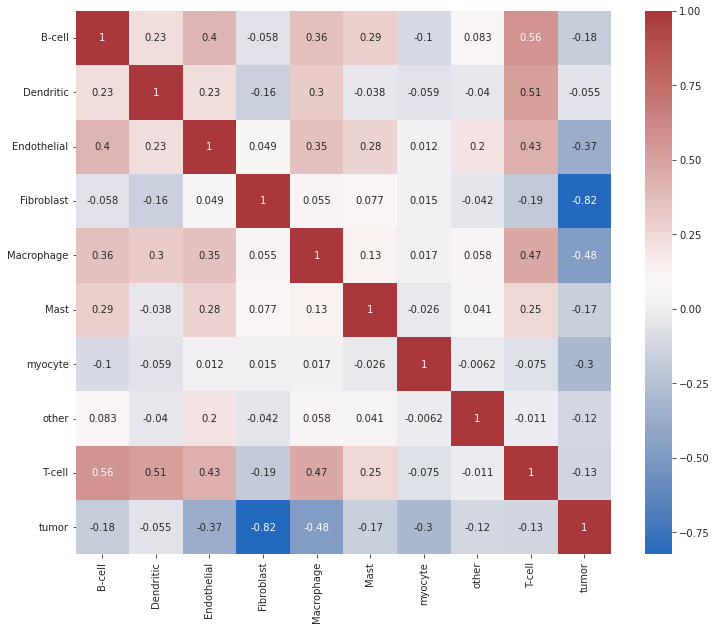

In [322]:
# cell type fractions correlations heatmap
plt.subplots(figsize=(12,10))
sns.heatmap(df_merged.iloc[:,:10].corr(),cmap="vlag",annot=True,)

<AxesSubplot:>

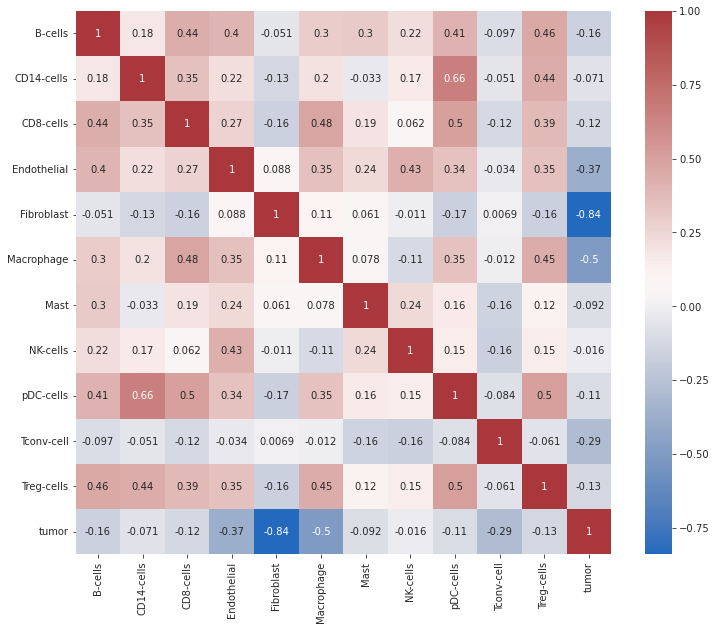

In [323]:
# cell type fractions correlations heatmap
plt.subplots(figsize=(12,10))
sns.heatmap(df_merged_subtypes.iloc[:,:13].corr(),cmap="vlag",annot=True,)

Text(0.5, 1.0, 'Deconvolved TCGA samples FGA distribution')

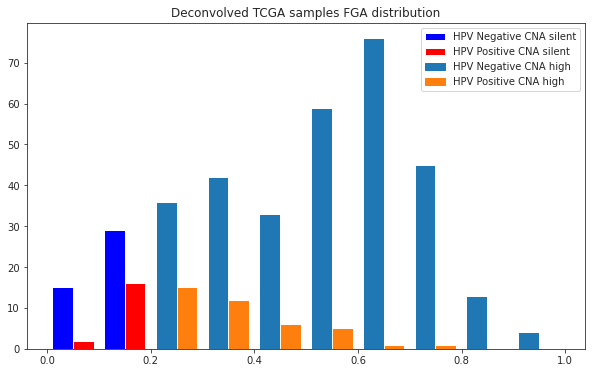

In [324]:
fig, ax = plt.subplots(figsize=(10, 6))
data_distribution = [df_merged_relative[df_merged_relative['hpv_status']=='Negative']['fga'].to_numpy(),df_merged_relative[df_merged_relative['hpv_status']=='Positive']['fga'].to_numpy()]
N, bins, patches = ax.hist(data_distribution,bins=10,label=['HPV Negative','HPV Positive'],color=['tab:blue','tab:orange'])
# ax = df_merged_relative.plot(kind='hist',column='fga',by='hpv_status',figsize=(10, 8),cumulative=True,
#                         title=['HPV negative sample FGA distribution','HPV positive sample FGA distribution'],sharex=True)

patches[0][0].set_facecolor('blue')
patches[0][1].set_facecolor('blue')
patches[1][0].set_facecolor('red')
patches[1][1].set_facecolor('red')

ax.legend(['HPV Negative CNA silent','HPV Positive CNA silent','HPV Negative CNA high','HPV Positive CNA high'])
leg = ax.get_legend()
leg.legendHandles[2].set_color('tab:blue')
leg.legendHandles[3].set_color('tab:orange')

ax.set_title('Deconvolved TCGA samples FGA distribution')

In [325]:
group_HPVneg = pd.DataFrame(df_merged_HPVneg_relative.groupby('FGA_status')['primary_site'].value_counts(sort=False))
group_HPVneg['label'] = [i[1] for i in group_HPVneg.index]
group_HPVneg = group_HPVneg.sort_values(['FGA_status','label'])
group_HPVneg

primary_site        label
FGA_status primary_site                           
High       Hypopharynx              6  Hypopharynx
           Larynx                  99       Larynx
           Oral Cavity            182  Oral Cavity
           Oropharynx              21   Oropharynx
Silent     Hypopharynx              1  Hypopharynx
           Larynx                   5       Larynx
           Oral Cavity             36  Oral Cavity
           Oropharynx               2   Oropharynx

### From which anatomical sites are the HPV-negative CNA-silent cases? 
> How many oral cavity, how many hypopharynx etc? Make a table of the silent cases and which anatomical locations they are. 

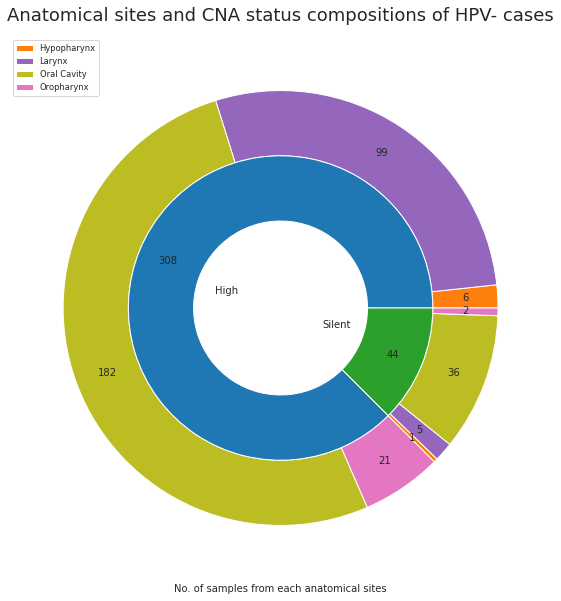

In [340]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Anatomical sites and CNA status compositions of HPV- cases', fontsize=18, pad=15)

size = 0.3
# colors={'Hypopharynx':'tab:orange','Larynx':'tab:purple','Oral Cavity':'tab:olive','Oropharynx':'tab:pink'}
colors = ['tab:orange', 'tab:purple','tab:olive','tab:pink']
colors_CNA = ['tab:blue','tab:green']

# colors = [plt.cm.Spectral(i) for i in np.linspace(0, 1, 4)]
ax.set_prop_cycle('color', colors)
ax.pie(group_HPVneg['primary_site'],radius=1,wedgeprops=dict(width=size,edgecolor='w'),colors = colors,
           autopct=lambda x: '{:.0f}'.format(x*group_HPVneg['primary_site'].sum()/100),pctdistance=0.85,
      )

ax.pie(group_HPVneg.groupby('FGA_status')['primary_site'].sum(),radius=1-size,wedgeprops=dict(width=size,edgecolor='w'),
       labels = df_merged_HPVneg_relative['FGA_status'].value_counts(sort=False).index.tolist(),autopct=lambda x: '{:.0f}'.format(x*df_merged_HPVneg_relative['FGA_status'].value_counts().sum()/100),
      pctdistance=0.80,labeldistance = 0.3,colors = colors_CNA)

ax.legend(group_HPVneg['label'].value_counts(sort=False).index,fontsize='small',)
ax.set_xlabel("No. of samples from each anatomical sites")
plt.show()

Text(0.5, 1.0, 'Anatomical sites of HPV- CNA silent cases')

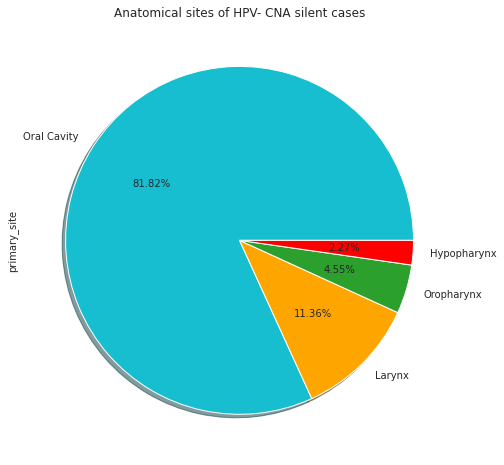

In [331]:
statistic_hpvneg_silent = df_merged_HPVneg_relative[df_merged_HPVneg_relative['FGA_status']=='Silent']['primary_site']
ax = statistic_hpvneg_silent.value_counts().plot(kind='pie',autopct=lambda x: '{:.2f}%'.format(x),figsize=(8, 8),shadow=True,colors=['tab:cyan','orange','tab:green','red'])
ax.set_title('Anatomical sites of HPV- CNA silent cases')

In [332]:
group_HPVpos = pd.DataFrame(df_merged_HPVpos_relative.groupby('FGA_status')['primary_site'].value_counts(sort=False))
group_HPVpos['label'] = [i[1] for i in group_HPVpos.index]
group_HPVpos = group_HPVpos.sort_values(['FGA_status','label'])
group_HPVpos

primary_site        label
FGA_status primary_site                           
High       Hypopharynx              1  Hypopharynx
           Oral Cavity              7  Oral Cavity
           Oropharynx              32   Oropharynx
Silent     Hypopharynx              1  Hypopharynx
           Larynx                   1       Larynx
           Oral Cavity              2  Oral Cavity
           Oropharynx              14   Oropharynx

###  How much HPV-positive cases do we have? 
### From which anatomical site are they (we expect only oropharynx)? 
> Make a table. Also, just out of curiosity, what is the FGA for these tumors? 

In [333]:
print("We gathered",len(set_pos),"Positive samples from two source") 

We gathered 72 Positive samples from two source


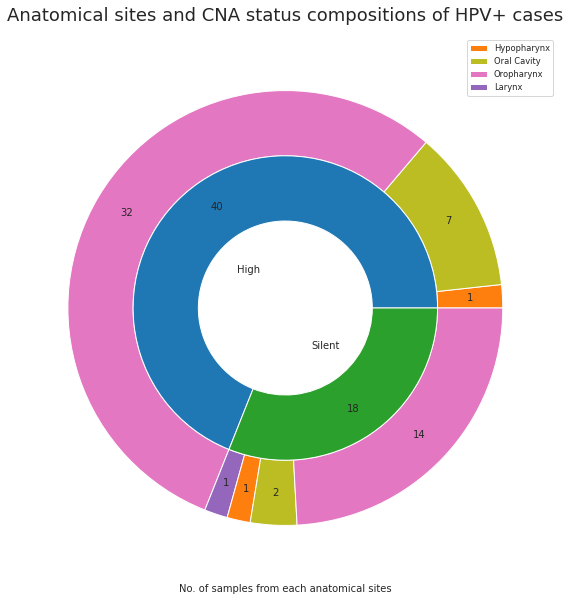

In [344]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Anatomical sites and CNA status compositions of HPV+ cases', fontsize=18, pad=15)

size = 0.3
# colors={'Hypopharynx':'tab:orange','Larynx':'tab:purple','Oral Cavity':'tab:olive','Oropharynx':'tab:pink'}

colors = ['tab:orange','tab:olive','tab:pink','tab:purple']
colors_CNA = ['tab:blue','tab:green']

# colors = [plt.cm.Spectral(i) for i in np.linspace(0, 1, 4)]
ax.set_prop_cycle('color', colors)
ax.pie(group_HPVpos['primary_site'],radius=1,wedgeprops=dict(width=size,edgecolor='w'),colors = colors,
           autopct=lambda x: '{:.0f}'.format(x*group_HPVpos['primary_site'].sum()/100),pctdistance=0.85,
      )

ax.pie(group_HPVpos.groupby('FGA_status')['primary_site'].sum(),radius=1-size,wedgeprops=dict(width=size,edgecolor='w'),
       labels = df_merged_HPVpos_relative['FGA_status'].value_counts(sort=False).index.tolist(),autopct=lambda x: '{:.0f}'.format(x*df_merged_HPVpos_relative['FGA_status'].value_counts().sum()/100),
      pctdistance=0.80,labeldistance = 0.3,colors = colors_CNA)

ax.legend(group_HPVpos['label'].value_counts().index,fontsize='small')
ax.set_xlabel("No. of samples from each anatomical sites")
plt.show()

Text(0.5, 1.0, 'Anatomical sites of HPV+ cases')

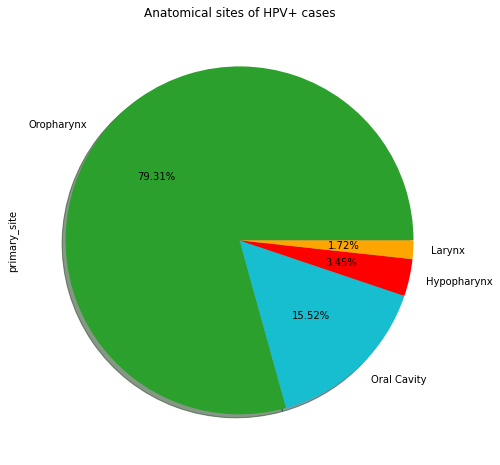

In [39]:
statistic_hpvpos = df_merged_HPVpos_relative['primary_site']
ax = statistic_hpvpos.value_counts().plot(kind='pie',autopct=lambda x: '{:.2f}%'.format(x),figsize=(8, 8),shadow=True,colors=['tab:green','tab:cyan','red','orange'])
ax.set_title('Anatomical sites of HPV+ cases')

### Compare cell type compositions between samples with two CNA status 
- Copy number alteration groups, all cell types (CNA-silent, nonsilent with cut-off FGA 0.20)
- HPV-, all Oral cavity

In [347]:
print("Number of CNA-high and CNA-silent samples that are also HPV-")
df_merged_HPVneg_fga_site_relative_OC['FGA_status'].value_counts()

Number of CNA-high and CNA-silent samples that are also HPV-


High      182
Silent     36
Name: FGA_status, dtype: int64

In [346]:
# comparison of CNA-silent vs –high of only oral cavity tumors. 
# This is a ‘’cleaner’’ comparison since anatomical site wouldn’t influence the results now, only looking at difference between silent and nonsilent in oral cavity. 
df_merged_HPVneg_fga_site_relative_OC = df_merged_HPVneg_relative[df_merged_HPVneg_relative['primary_site']=='Oral Cavity']

In [354]:
df_merged_HPVneg_melt = pd.melt(df_merged_HPVneg_fga_site_relative_OC,id_vars='FGA_status',value_vars=df_merged_HPVneg_fga_site_relative_OC.columns[:10].tolist())
df_merged_HPVneg_melt

FGA_status variable     value
0          High   B-cell  0.000027
1          High   B-cell  0.002827
2          High   B-cell  0.046388
3        Silent   B-cell  0.000070
4          High   B-cell  0.000222
...         ...      ...       ...
2175       High    tumor  0.508952
2176       High    tumor  0.942446
2177       High    tumor  0.551284
2178       High    tumor  0.926642
2179       High    tumor  0.663102

[2180 rows x 3 columns]

TypeError: loop of ufunc does not support argument 0 of type str which has no callable log10 method

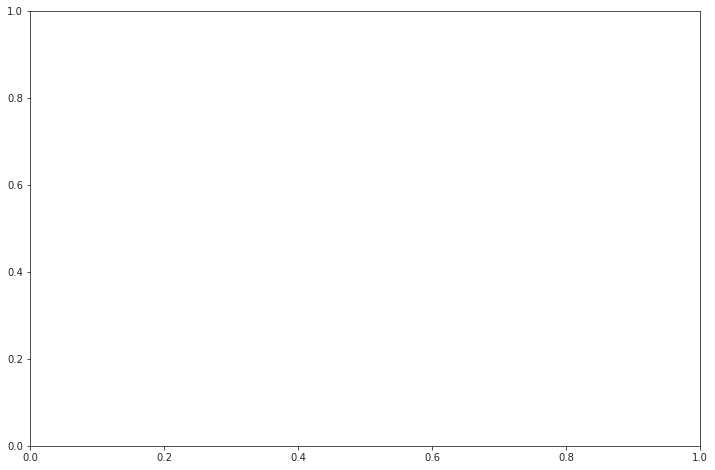

In [355]:
plt.subplots(figsize=(12,8))
sns.boxplot(x='variable',y='value',hue='FGA_status',data=np.log10(df_merged_HPVneg_melt))
sns.despine(left=True)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

### Zoom in: Immune cells only

In [44]:
df_merged_HPVneg_immune_relative = df_merged_HPVneg.copy()[['B-cell','Dendritic','Macrophage','Mast','T-cell','fga','FGA_status','sample_match','primary_site','hpv_status']]
df_merged_HPVneg_immune_relative.iloc[:,:5] = df_merged_HPVneg_immune_relative.iloc[:,:5].div(df_merged_HPVneg_immune_relative.iloc[:,:5].sum(axis=1),axis=0)
# df_merged_HPVneg_immune_relative

In [45]:
df_merged_HPVneg_immune_relative_OC = df_merged_HPVneg_immune_relative[df_merged_HPVneg_immune_relative['primary_site']=='Oral Cavity']
df_merged_HPVneg_immune_melt = pd.melt(df_merged_HPVneg_immune_relative_OC,id_vars='FGA_status',value_vars=df_merged_HPVneg_immune_relative_OC.columns[:5].tolist())
df_merged_HPVneg_immune_melt

FGA_status variable     value
0          High   B-cell  0.000072
1          High   B-cell  0.015918
2          High   B-cell  0.361085
3        Silent   B-cell  0.000104
4          High   B-cell  0.001220
...         ...      ...       ...
1085       High   T-cell  0.189396
1086       High   T-cell  0.204138
1087       High   T-cell  0.129280
1088       High   T-cell  0.314306
1089       High   T-cell  0.119505

[1090 rows x 3 columns]

Text(0, 0.5, 'Cell type fractions')

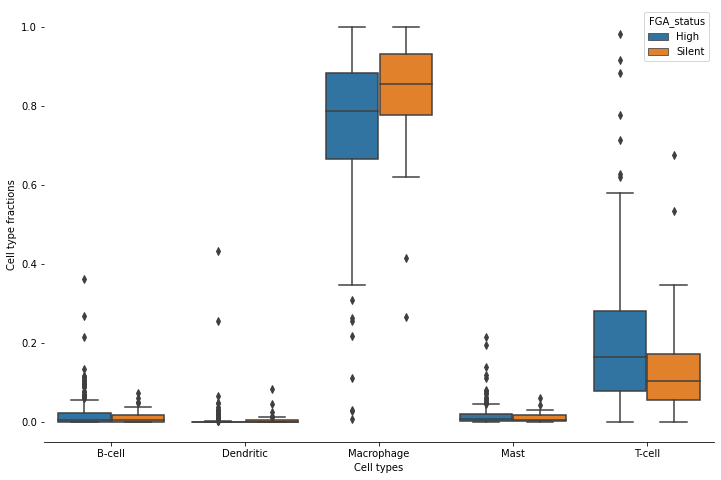

In [46]:
#
plt.subplots(figsize=(12,8))
sns.boxplot(x='variable',y='value',hue='FGA_status',data=df_merged_HPVneg_immune_melt)
sns.despine(left=True)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

### Zoom in: Deconvolution results from immune subtypes

In [47]:
# comparison of CNA-silent vs –high of only oral cavity tumors. 
# This is a ‘’cleaner’’ comparison since anatomical site wouldn’t influence the results now, only looking at difference between silent and nonsilent in oral cavity. 
df_merged_HPVneg_subtypes_relative_OC = df_merged_HPVneg_subtypes_relative[df_merged_HPVneg_subtypes_relative['primary_site']=='Oral Cavity']

In [48]:
df_merged_HPVneg_subtypes_melt = pd.melt(df_merged_HPVneg_subtypes_relative_OC,id_vars='FGA_status',value_vars=df_merged_HPVneg_subtypes_relative_OC.columns[:12].tolist())
df_merged_HPVneg_subtypes_melt

FGA_status variable     value
0          High  B-cells  0.000010
1          High  B-cells  0.001784
2          High  B-cells  0.068612
3        Silent  B-cells  0.000008
4          High  B-cells  0.000220
...         ...      ...       ...
2611       High    tumor  0.495619
2612       High    tumor  0.961818
2613       High    tumor  0.557172
2614       High    tumor  0.935906
2615       High    tumor  0.665725

[2616 rows x 3 columns]

Text(0, 0.5, 'Cell type fractions')

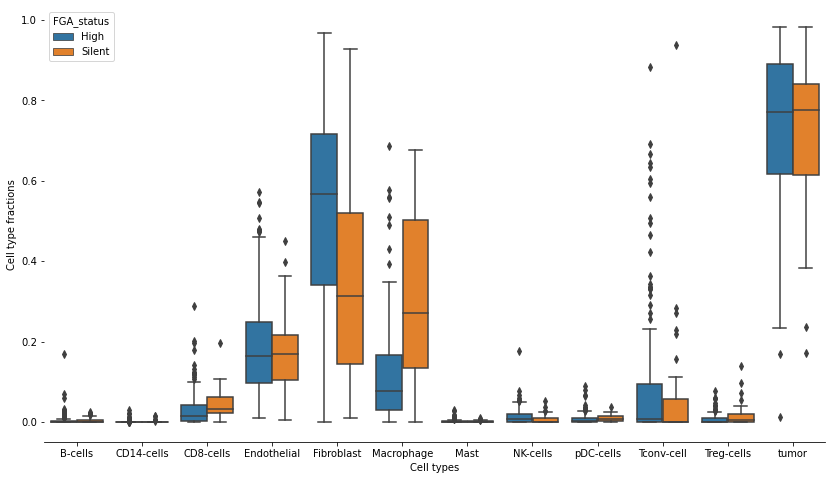

In [49]:
#
plt.subplots(figsize=(14,8))
sns.boxplot(x='variable',y='value',hue='FGA_status',data=df_merged_HPVneg_subtypes_melt)
sns.despine(left=True)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

In [50]:
# Immune cells only
df_merged_HPVneg_subtypes_immune_relative = df_merged_HPVneg_subtypes.copy()[['B-cells','CD14-cells','CD8-cells','Macrophage','NK-cells','pDC-cells','Mast','Tconv-cell','Treg-cells','fga','FGA_status','sample_match','primary_site','hpv_status']]
df_merged_HPVneg_subtypes_immune_relative.iloc[:,:9] = df_merged_HPVneg_subtypes_immune_relative.iloc[:,:9].div(df_merged_HPVneg_subtypes_immune_relative.iloc[:,:9].sum(axis=1),axis=0)
# df_merged_HPVneg_subtypes_immune_relative

In [51]:
df_merged_HPVneg_subtypes_immune_relative_OC = df_merged_HPVneg_subtypes_immune_relative[df_merged_HPVneg_subtypes_immune_relative['primary_site']=='Oral Cavity']
df_merged_HPVneg_subtypes_immune_melt = pd.melt(df_merged_HPVneg_subtypes_immune_relative_OC,id_vars='FGA_status',value_vars=df_merged_HPVneg_subtypes_immune_relative_OC.columns[:9].tolist())
df_merged_HPVneg_subtypes_immune_melt

FGA_status    variable     value
0          High     B-cells  0.000022
1          High     B-cells  0.003751
2          High     B-cells  0.467509
3        Silent     B-cells  0.000011
4          High     B-cells  0.001226
...         ...         ...       ...
1957       High  Treg-cells  0.006036
1958       High  Treg-cells  0.013079
1959       High  Treg-cells  0.020171
1960       High  Treg-cells  0.000653
1961       High  Treg-cells  0.048080

[1962 rows x 3 columns]

Text(0, 0.5, 'Cell type fractions')

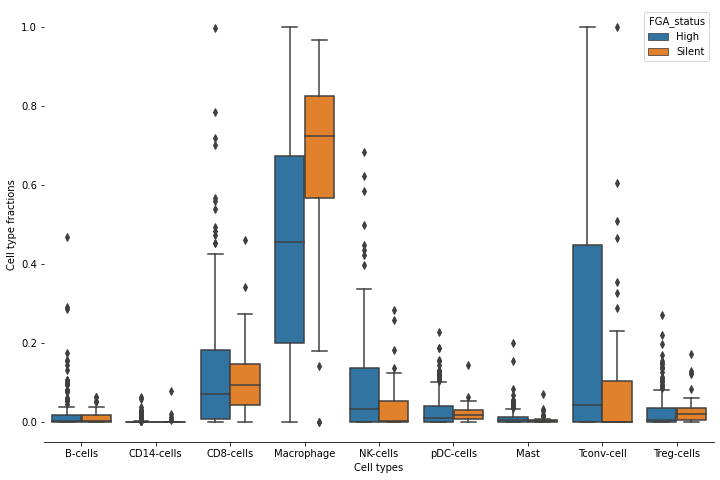

In [52]:
plt.subplots(figsize=(12,8))
sns.boxplot(x='variable',y='value',hue='FGA_status',data=df_merged_HPVneg_subtypes_immune_melt)
sns.despine(left=True)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

### Visualizations below requires resampling to alleviate the effect of class-imbalance!
#### We do not wish to lose any valuable CNA-high samples, therefore use SMOTE (Synthetic Minority Oversampling) algorithm to upsample CNA silent group, as a result we have equal number of CNA-high and silent samples

In [112]:
sm = imblearn.over_sampling.SMOTE()
list_col = df_merged_HPVneg_fga_site_relative_OC.columns[:10].tolist()
list_col.append('fga')

X_train, y_train = sm.fit_resample(df_merged_HPVneg_fga_site_relative_OC.loc[:,list_col].to_numpy(),df_merged_HPVneg_fga_site_relative_OC['FGA_status'])
print('Resampled dataset shape %s' % len(y_train))
print(y_train.value_counts())

Resampled dataset shape 364
High      182
Silent    182
Name: FGA_status, dtype: int64


In [113]:
df_afterSMOTE = pd.DataFrame(X_train,columns=list_col)
df_afterSMOTE['FGA_status'] = y_train
# df_afterSMOTE

In [114]:
df_afterSMOTE_melt = pd.melt(df_afterSMOTE,id_vars='FGA_status',value_vars=df_merged_HPVneg_fga_site_relative_OC.columns[:10].tolist())
# df_afterSMOTE_melt

In [115]:
df_afterSMOTE_melt_log = df_afterSMOTE_melt.copy()
df_afterSMOTE_melt_log['value'] = df_afterSMOTE_melt_log['value'].apply(np.log)

### Draw a categorical scatterplot to show each observation, cell type fractions are log transformed to speed up visualization and spread data points out

[Text(0.5, 0, 'log-transfomed Oral Cavity Cell type percentage SWARMs across CNA status after SMOTE resampling')]

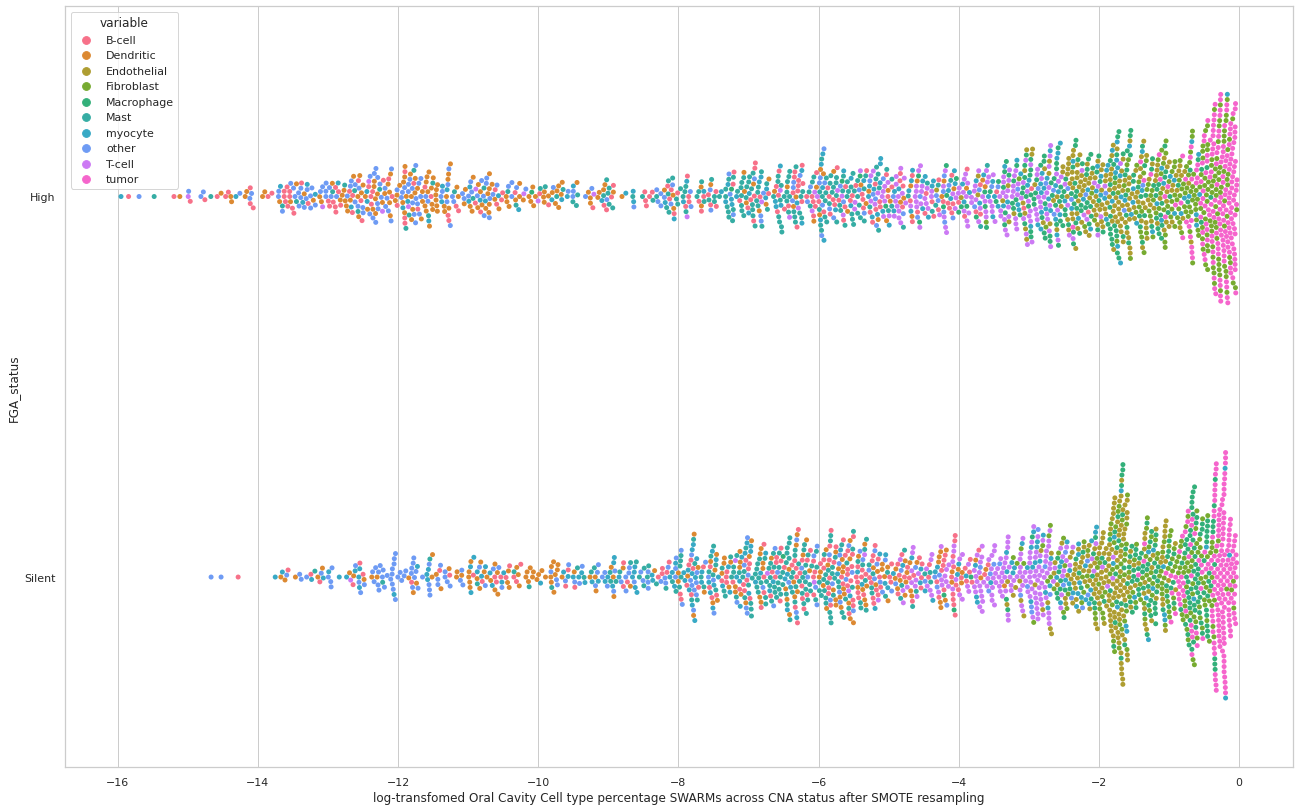

In [106]:
# Draw a categorical scatterplot to show each observation
plt.subplots(figsize=(22,14))
sns.set_theme(style="whitegrid", palette="muted")
ax = sns.swarmplot(data=df_afterSMOTE_melt_log, x="value", y="FGA_status", hue="variable",palette=sns.husl_palette(10))
ax.set(xlabel="log-transfomed Oral Cavity Cell type percentage SWARMs across CNA status after SMOTE resampling")

In [108]:
# decon result with immune subtypes
sm = imblearn.over_sampling.SMOTE()
list_col = df_merged_HPVneg_subtypes_relative_OC.columns[:12].tolist()
list_col.append('fga')

X_train, y_train = sm.fit_resample(df_merged_HPVneg_subtypes_relative_OC.loc[:,list_col].to_numpy(),df_merged_HPVneg_subtypes_relative_OC['FGA_status'])
print('Resampled dataset shape %s' % len(y_train))
print(y_train.value_counts())

Resampled dataset shape 364
High      182
Silent    182
Name: FGA_status, dtype: int64


In [109]:
df_afterSMOTE = pd.DataFrame(X_train,columns=list_col)
df_afterSMOTE['FGA_status'] = y_train
# df_afterSMOTE
df_afterSMOTE_melt = pd.melt(df_afterSMOTE,id_vars='FGA_status',value_vars=df_merged_HPVneg_subtypes_relative_OC.columns[:12].tolist())
# df_afterSMOTE_melt
df_afterSMOTE_melt_log = df_afterSMOTE_melt.copy()
df_afterSMOTE_melt_log['value'] = df_afterSMOTE_melt_log['value'].apply(np.log)

[Text(0.5, 0, 'log-transfomed Oral Cavity immune cell subtype percentage SWARMs across CNA status after SMOTE resampling')]

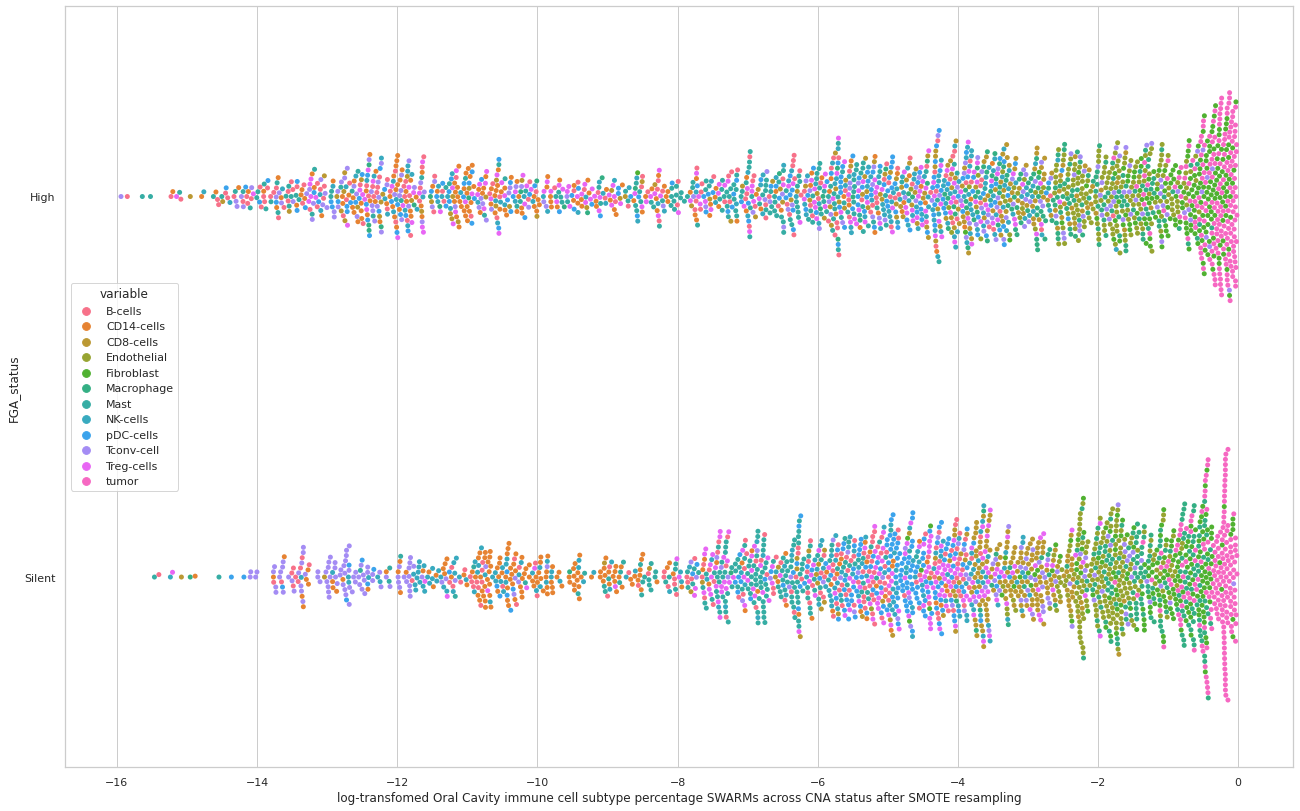

In [111]:
# Draw a categorical scatterplot to show each observation
plt.subplots(figsize=(22,14))
sns.set_theme(style="whitegrid", palette="muted")
ax = sns.swarmplot(data=df_afterSMOTE_melt_log, x="value", y="FGA_status", hue="variable",
                  palette=sns.husl_palette(12))
ax.set(xlabel="log-transfomed Oral Cavity immune cell subtype percentage SWARMs across CNA status after SMOTE resampling")

### Try to visualize Top Principle Component of 10 sets of cell type fractions for all samples
> Dim reduction to reduce features: 10 cell types as feature -> 1 PC as feature
 
>May help capture the hidden pattern within compositions

In [116]:
# pca and minmax scale
mmscaler = MinMaxScaler()

[0.52514002 0.2560835 ]


Text(0.5, 1.0, 'CNA-high group 2-component PCA')

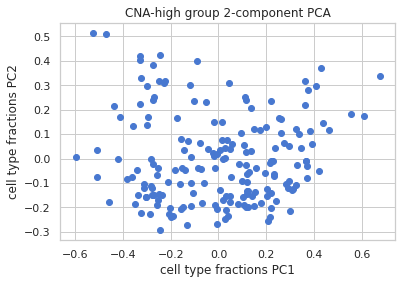

In [117]:
df_mat = df_afterSMOTE[df_afterSMOTE['FGA_status']=='High'].drop(['FGA_status','fga'],axis=1)
pca = PCA(n_components=2)
pca.fit(df_mat)
print(pca.explained_variance_ratio_)
plt.scatter(pca.transform(df_mat)[:,0],pca.transform(df_mat)[:,1])
plt.xlabel("cell type fractions PC1")
plt.ylabel("cell type fractions PC2")
plt.title("CNA-high group 2-component PCA")

[0.54900343 0.28252632]


Text(0.5, 1.0, 'CNA-silent group 2-component PCA')

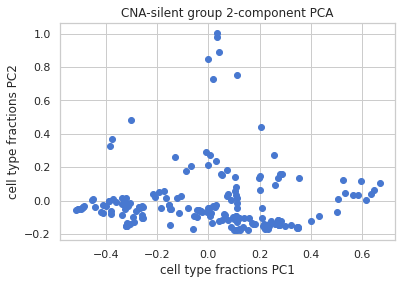

In [118]:
df_mat = df_afterSMOTE[df_afterSMOTE['FGA_status']=='Silent'].drop(['FGA_status','fga'],axis=1)
pca = PCA(n_components=2)
pca.fit(df_mat)
print(pca.explained_variance_ratio_)
plt.scatter(pca.transform(df_mat)[:,0],pca.transform(df_mat)[:,1])
plt.xlabel("cell type fractions PC1")
plt.ylabel("cell type fractions PC2")
plt.title("CNA-silent group 2-component PCA")

### PCA: Decon with Immune subtypes

[0.5154524  0.25581386]


Text(0.5, 1.0, 'CNA-high group 2-component PCA')

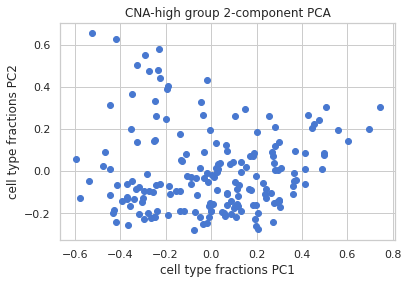

In [64]:
df_mat = df_afterSMOTE[df_afterSMOTE['FGA_status']=='High'].drop(['FGA_status','fga'],axis=1)
pca = PCA(n_components=2)
pca.fit(df_mat)
print(pca.explained_variance_ratio_)
plt.scatter(pca.transform(df_mat)[:,0],pca.transform(df_mat)[:,1])
plt.xlabel("cell type fractions PC1")
plt.ylabel("cell type fractions PC2")
plt.title("CNA-high group 2-component PCA")

[0.61159488 0.22463816]


Text(0.5, 1.0, 'CNA-silent group 2-component PCA')

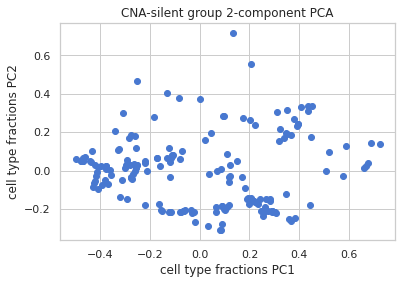

In [65]:
df_mat = df_afterSMOTE[df_afterSMOTE['FGA_status']=='Silent'].drop(['FGA_status','fga'],axis=1)
pca = PCA(n_components=2)
pca.fit(df_mat)
print(pca.explained_variance_ratio_)
plt.scatter(pca.transform(df_mat)[:,0],pca.transform(df_mat)[:,1])
plt.xlabel("cell type fractions PC1")
plt.ylabel("cell type fractions PC2")
plt.title("CNA-silent group 2-component PCA")

### FGA high vs silent groups: TME shown per cell type per CNA group
- x-axis: FGA
- y-axis: minmax scaled cell type fractions, upper row of sub-plots: CNA-high, lower row of sub-plots: CNA-silent
- size and color of data points: cell type fractions

> Purpose of minmax scale normalization: hard to directly compare scatterplot with two different y-axis limits (0-0.2 and 0.2-1.0)

> Problem: data shown in this plot did not undergo SMOTE resampling so the 

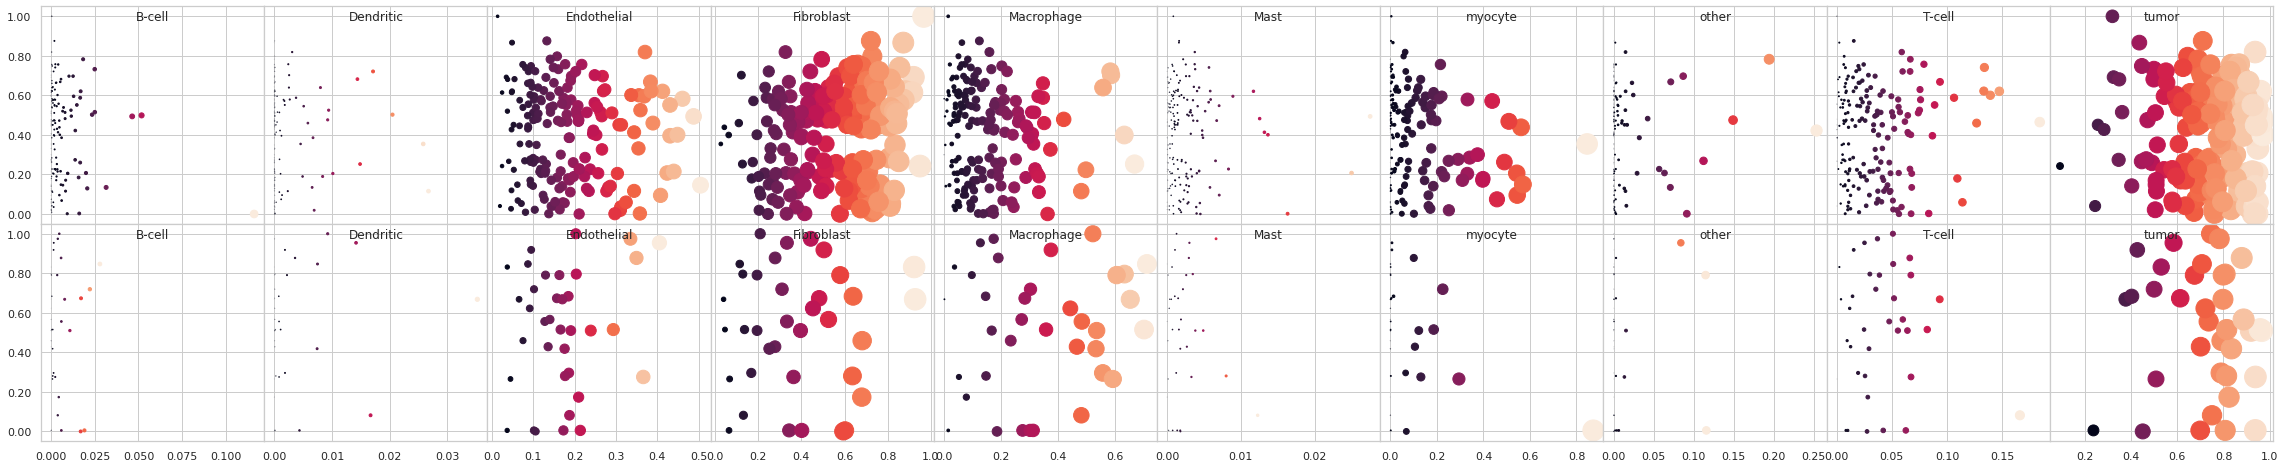

In [66]:
# Visualize fga high vs silent groups cell type compostions
fig,ax = plt.subplots(2,10,figsize=(40,8),sharey='row',sharex='col')
mmscaler = MinMaxScaler()
celltypecount = 10
count=0
for i in df_merged.columns[:celltypecount]:
    y = mmscaler.fit_transform(df_merged_HPVneg_fga_site_relative_OC['fga'][df_merged_HPVneg_fga_site_relative_OC['FGA_status']=='High'].values.reshape(-1,1))
#     x = df_merged['cellularity'][df_merged['FGA_status']=='High']
    z = df_merged_HPVneg_fga_site_relative_OC[i][df_merged_HPVneg_fga_site_relative_OC['FGA_status']=='High'] # celltype fractions, non malignant relative 
    ax[0,count].scatter(z,y,c=z,s=z*500)
    ax[0,count].set_title(i,y=1.0, pad=-14)
    ax[0,count].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    count+=1
count=0

for i in df_merged.columns[:celltypecount]:
    y = mmscaler.fit_transform(df_merged_HPVneg_fga_site_relative_OC['fga'][df_merged_HPVneg_fga_site_relative_OC['FGA_status']=='Silent'].values.reshape(-1,1))
#     x = df_merged['cellularity'][df_merged['FGA_status']=='Silent']
    z = df_merged_HPVneg_fga_site_relative_OC[i][df_merged_HPVneg_fga_site_relative_OC['FGA_status']=='Silent']# celltype fractions, non malignant relative 
    ax[1,count].scatter(z,y,c=z,s=z*500)
    ax[1,count].set_title(i,y=1.0, pad=-14)
    ax[1,count].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    count+=1
count=0

plt.subplots_adjust(wspace=0, hspace=0)

## Compare TME compostions between anatomical site groups

In [348]:
print("Number of HPV- samples from each anatomical sites")
df_merged_HPVneg_relative['primary_site'].value_counts()

Number of HPV- samples from each anatomical sites


Oral Cavity    218
Larynx         104
Oropharynx      23
Hypopharynx      7
Name: primary_site, dtype: int64

In [349]:
df_merged_sites_HPVneg_melt = pd.melt(df_merged_HPVneg_relative,id_vars='primary_site',value_vars=df_merged_HPVneg_relative.columns[:10].tolist())
# df_merged_sites_HPVneg_melt

Text(0, 0.5, 'Cell type fractions')

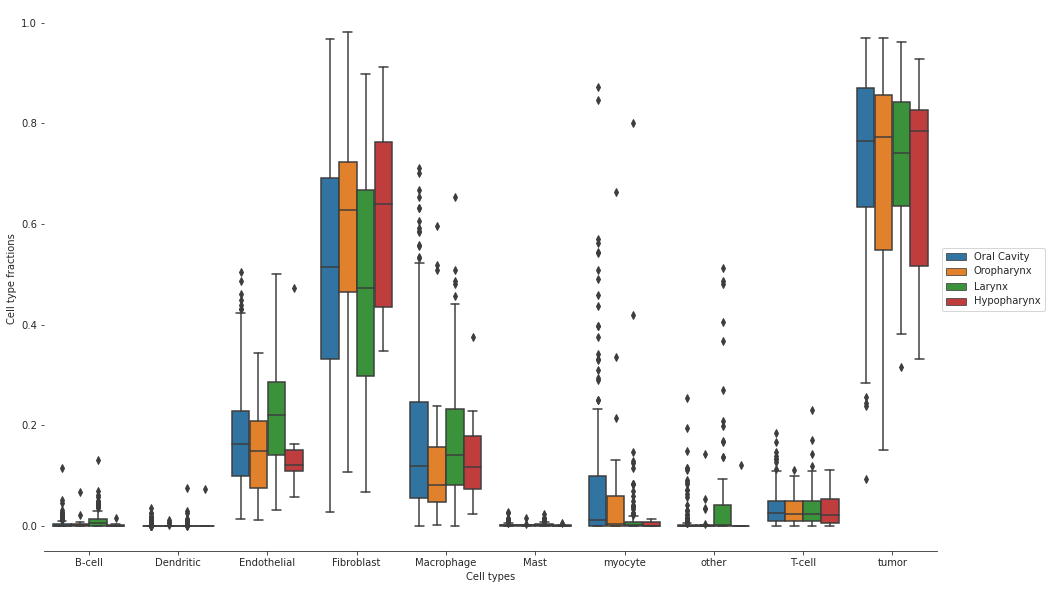

In [350]:
plt.subplots(figsize=(16,10))
sns.boxplot(x='variable',y='value',hue='primary_site',data=df_merged_sites_HPVneg_melt)
sns.despine(left=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=10)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

### Zoom in: Immune cells only

Text(0, 0.5, 'Cell type fractions')

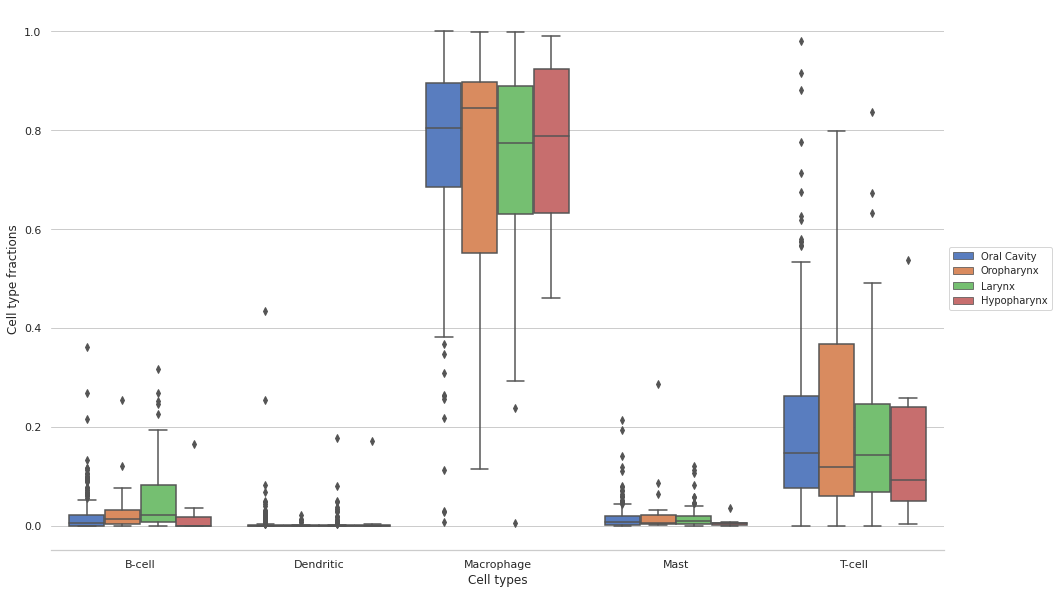

In [70]:
# Immune cells only
df_merged_HPVneg_immune_melt_sites = pd.melt(df_merged_HPVneg_immune_relative,id_vars='primary_site',value_vars=df_merged_HPVneg_immune_relative.columns[:5].tolist())
# df_merged_HPVneg_immune_melt_sites

plt.subplots(figsize=(16,10))
sns.boxplot(x='variable',y='value',hue='primary_site',data=df_merged_HPVneg_immune_melt_sites)
sns.despine(left=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=10)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

### Zoom in: Decon result with subtypes

In [124]:
print("Number of HPV- samples from each anatomical sites")
df_merged_HPVneg_subtypes_relative['primary_site'].value_counts()

Number of HPV- samples from each anatomical sites


Oral Cavity    218
Larynx         104
Oropharynx      23
Hypopharynx      7
Name: primary_site, dtype: int64

In [125]:
df_merged_HPVneg_subtypes_sites_melt = pd.melt(df_merged_HPVneg_subtypes_relative,id_vars='primary_site',value_vars=df_merged_HPVneg_subtypes_relative.columns[:12].tolist())
df_merged_HPVneg_subtypes_sites_melt

primary_site variable         value
0     Oral Cavity  B-cells  1.035079e-05
1      Oropharynx  B-cells  6.581109e-03
2     Oral Cavity  B-cells  1.784009e-03
3      Oropharynx  B-cells  3.391915e-03
4          Larynx  B-cells  6.617029e-07
...           ...      ...           ...
4219  Oral Cavity    tumor  9.618175e-01
4220       Larynx    tumor  7.090638e-01
4221  Oral Cavity    tumor  5.571721e-01
4222  Oral Cavity    tumor  9.359061e-01
4223  Oral Cavity    tumor  6.657255e-01

[4224 rows x 3 columns]

Text(0, 0.5, 'Cell type fractions')

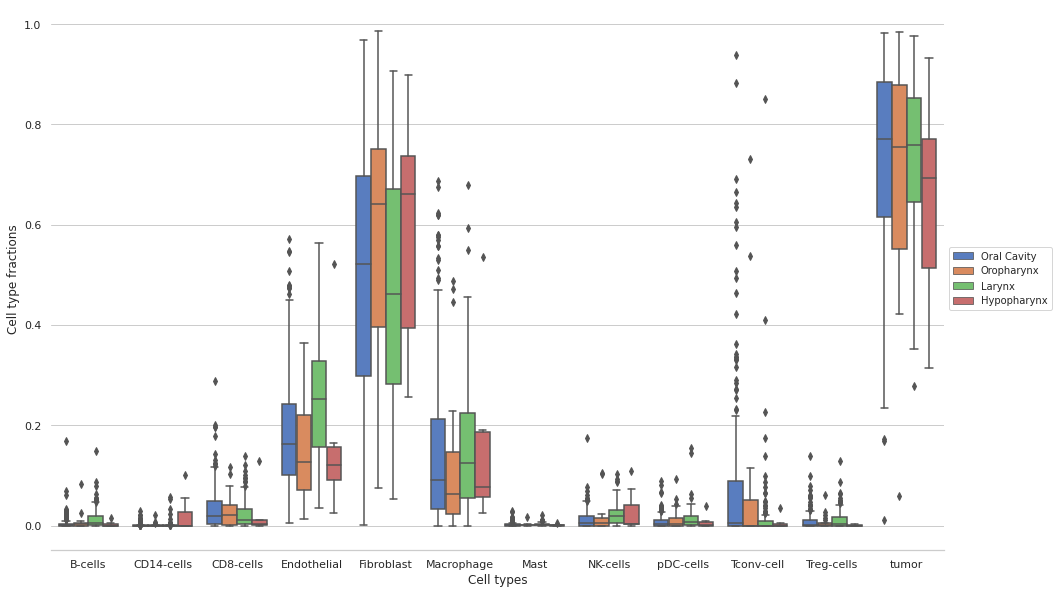

In [126]:
plt.subplots(figsize=(16,10))
sns.boxplot(x='variable',y='value',hue='primary_site',data=df_merged_HPVneg_subtypes_sites_melt)
sns.despine(left=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=10)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

In [127]:
# Immune cells only
df_merged_HPVneg_subtypes_sites_immune_melt = pd.melt(df_merged_HPVneg_subtypes_immune_relative,id_vars='primary_site',value_vars=df_merged_HPVneg_subtypes_immune_relative.columns[:9].tolist())
df_merged_HPVneg_subtypes_sites_immune_melt

primary_site    variable     value
0     Oral Cavity     B-cells  0.000022
1      Oropharynx     B-cells  0.024120
2     Oral Cavity     B-cells  0.003751
3      Oropharynx     B-cells  0.005713
4          Larynx     B-cells  0.000002
...           ...         ...       ...
3163  Oral Cavity  Treg-cells  0.013079
3164       Larynx  Treg-cells  0.000031
3165  Oral Cavity  Treg-cells  0.020171
3166  Oral Cavity  Treg-cells  0.000653
3167  Oral Cavity  Treg-cells  0.048080

[3168 rows x 3 columns]

Text(0, 0.5, 'Cell type fractions')

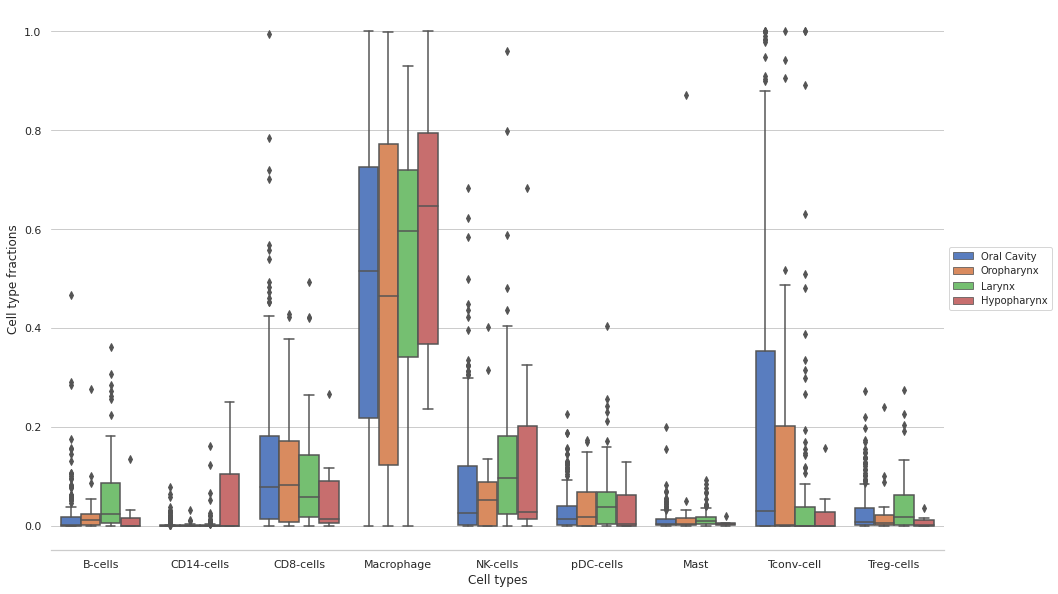

In [128]:
plt.subplots(figsize=(16,10))
sns.boxplot(x='variable',y='value',hue='primary_site',data=df_merged_HPVneg_subtypes_sites_immune_melt)
sns.despine(left=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=10)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

#### SWARM Pattern visualization

In [141]:
## Vis Methods below need resampling!
# SMOTE upsample CNA silent group

sm = imblearn.over_sampling.SMOTE()
list_col = df_merged_HPVneg_relative.columns[:10].tolist()

X_train, y_train = sm.fit_resample(df_merged_HPVneg_relative.loc[:,list_col].to_numpy(),df_merged_HPVneg_relative['primary_site'])
print('Resampled dataset shape %s' % len(y_train))
print(y_train.value_counts())

Resampled dataset shape 872
Oral Cavity    218
Oropharynx     218
Larynx         218
Hypopharynx    218
Name: primary_site, dtype: int64


In [142]:
df_afterSMOTE_site = pd.DataFrame(X_train,columns=list_col)
df_afterSMOTE_site['primary_site'] = y_train
# df_afterSMOTE_site

In [143]:
df_afterSMOTE_melt_site = pd.melt(df_afterSMOTE_site,id_vars='primary_site',value_vars=df_afterSMOTE_site.columns[:10].tolist())
# df_afterSMOTE_melt_site

In [144]:
df_afterSMOTE_melt_site_log = df_afterSMOTE_melt_site.copy()
df_afterSMOTE_melt_site_log['value'] = df_afterSMOTE_melt_site_log['value'].apply(np.log)

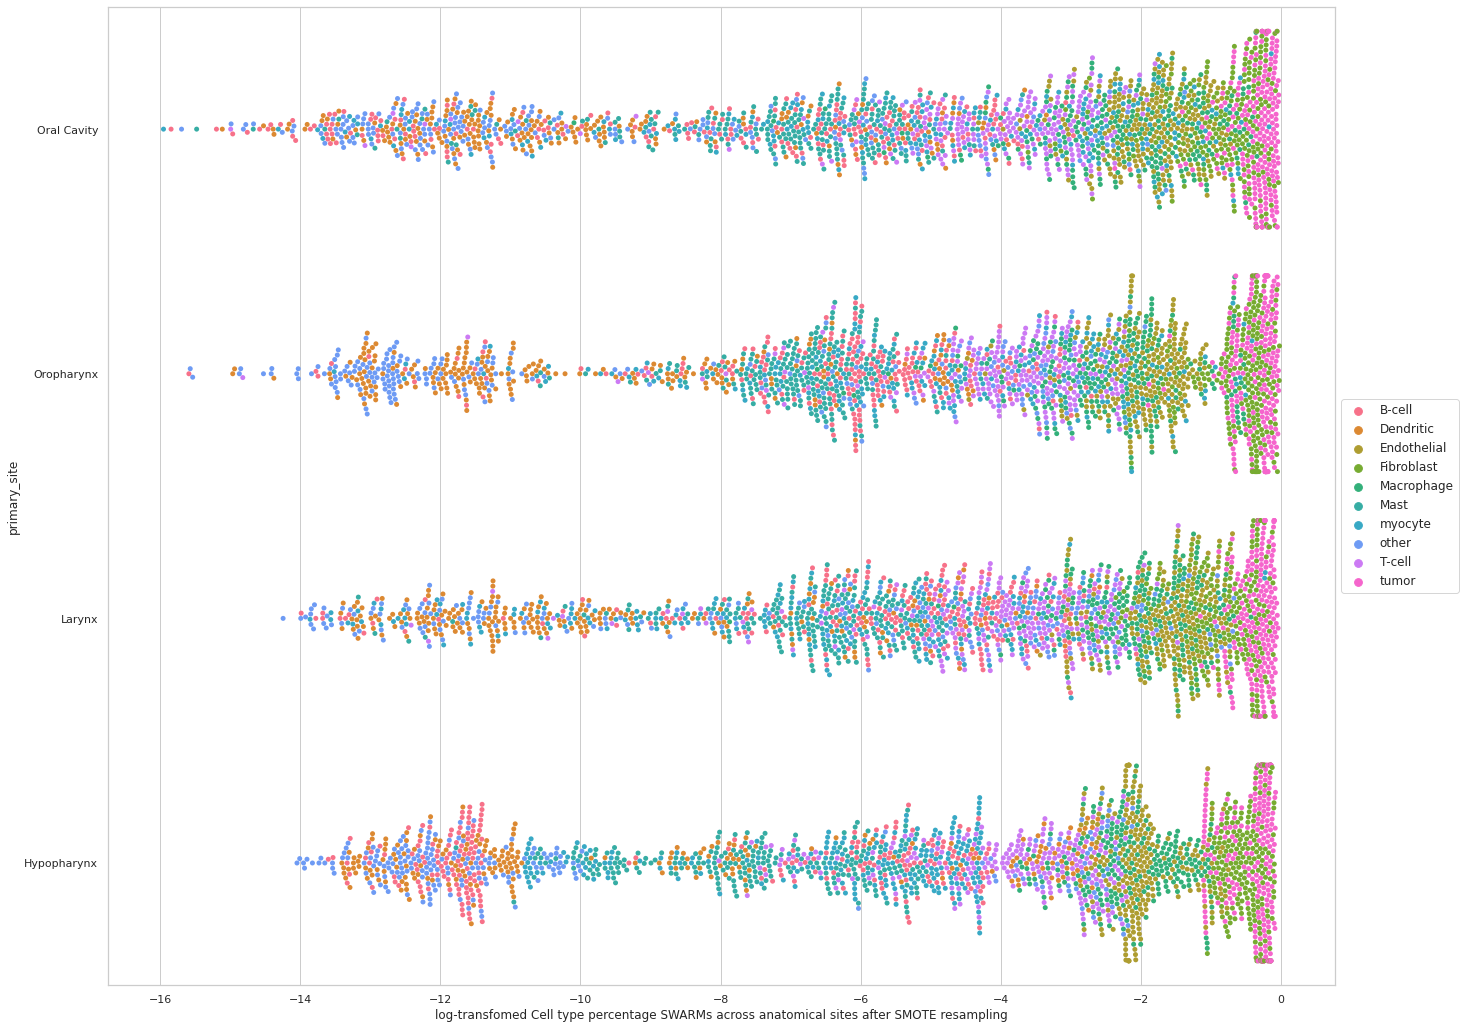

In [146]:
# Draw a categorical scatterplot to show each observation
plt.subplots(figsize=(22,18))
sns.set_theme(style="whitegrid", palette="muted")
ax = sns.swarmplot(data=df_afterSMOTE_melt_site_log, x="value", y="primary_site", hue="variable",
                   palette=sns.husl_palette(10))
ax.set(xlabel="log-transfomed Cell type percentage SWARMs across anatomical sites after SMOTE resampling")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=12)

In [147]:
# Decon result with immune subtypes
sm = imblearn.over_sampling.SMOTE()
list_col = df_merged_HPVneg_subtypes_relative.columns[:12].tolist()
# list_col.append('primary_site')

X_train, y_train = sm.fit_resample(df_merged_HPVneg_subtypes_relative.loc[:,list_col].to_numpy(),df_merged_HPVneg_subtypes_relative['primary_site'])
print('Resampled dataset shape %s' % len(y_train))
print(y_train.value_counts())

Resampled dataset shape 872
Oral Cavity    218
Oropharynx     218
Larynx         218
Hypopharynx    218
Name: primary_site, dtype: int64


In [148]:
df_afterSMOTE = pd.DataFrame(X_train,columns=list_col)
df_afterSMOTE['primary_site'] = y_train
# df_afterSMOTE
df_afterSMOTE_melt = pd.melt(df_afterSMOTE,id_vars='primary_site',value_vars=df_merged_HPVneg_subtypes_relative.columns[:12].tolist())
# df_afterSMOTE_melt
df_afterSMOTE_melt_log = df_afterSMOTE_melt.copy()
df_afterSMOTE_melt_log['value'] = df_afterSMOTE_melt_log['value'].apply(np.log)

[Text(0.5, 0, 'log-transfomed immune cell subtype percentage SWARMs across CNA status after SMOTE resampling')]

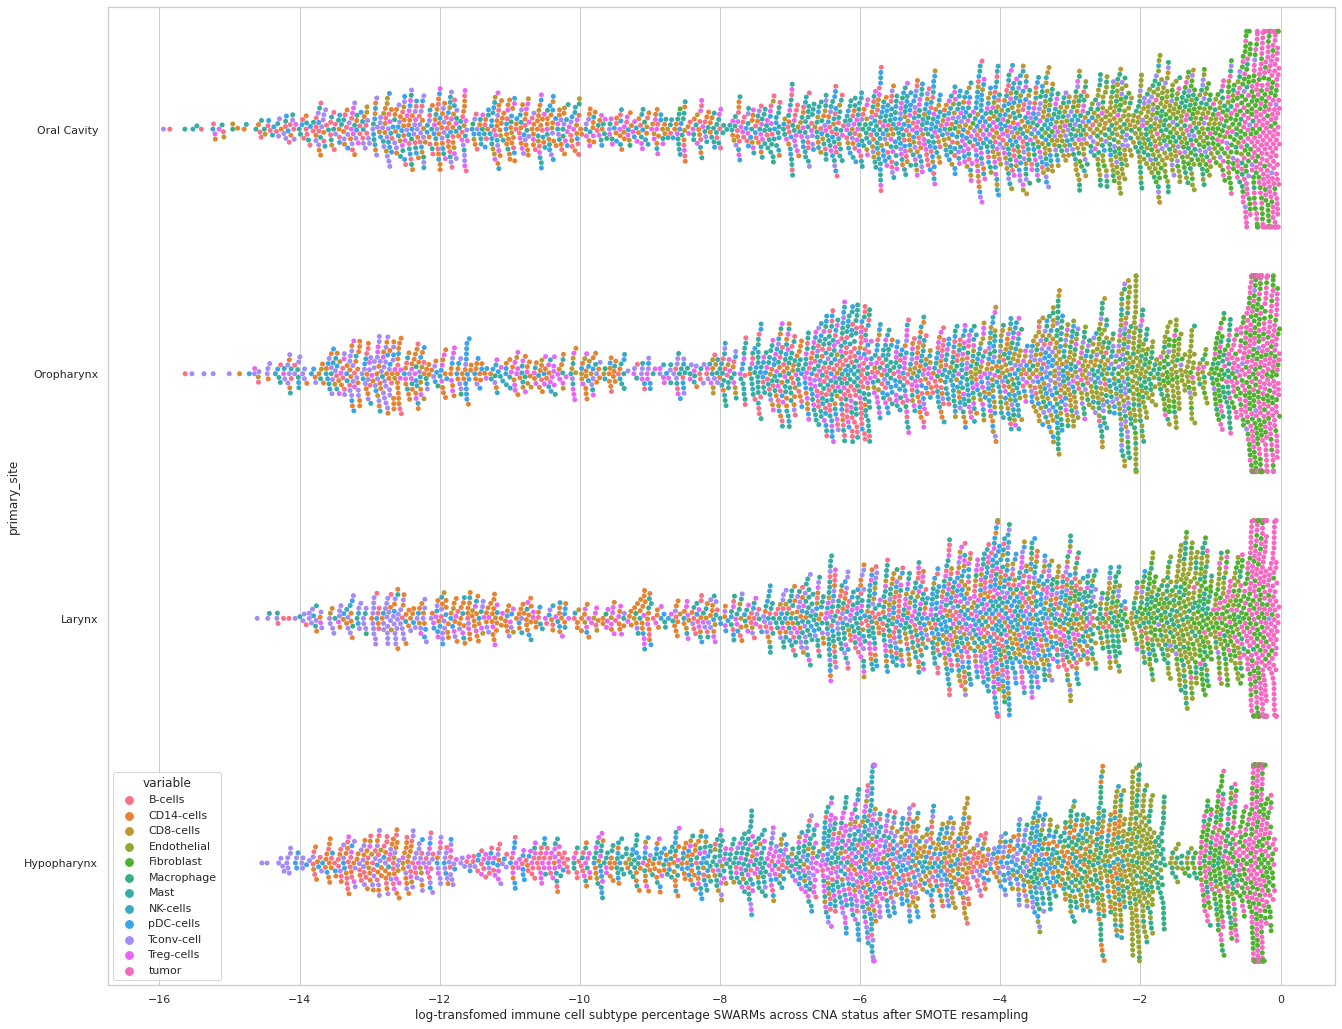

In [149]:
# Draw a categorical scatterplot to show each observation
plt.subplots(figsize=(22,18))
sns.set_theme(style="whitegrid", palette="muted")
ax = sns.swarmplot(data=df_afterSMOTE_melt_log, x="value", y="primary_site", hue="variable",
                  palette=sns.husl_palette(12))
ax.set(xlabel="log-transfomed immune cell subtype percentage SWARMs across CNA status after SMOTE resampling")

#### PCA

[0.51636286 0.24552473]
[0.59755995 0.24239947]
[0.54545006 0.22634817]
[0.73704219 0.1677444 ]


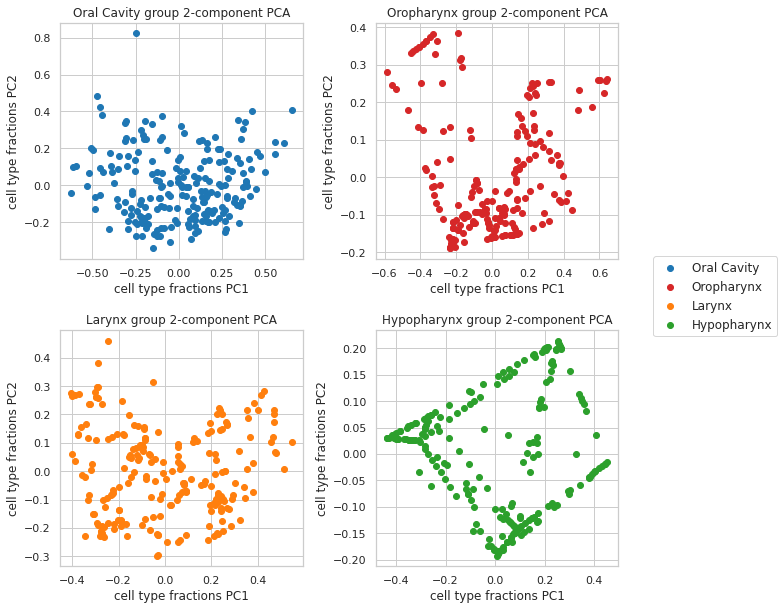

In [76]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
pic = 0
dict_color_sites = {'Oral Cavity':'tab:blue','Oropharynx':'tab:red','Larynx':'tab:orange','Hypopharynx':'tab:green'}
for i in df_afterSMOTE_site['primary_site'].unique():
    df_mat_site = df_afterSMOTE_site[df_afterSMOTE_site['primary_site']==i].drop(['primary_site'],axis=1)
    pca = PCA(n_components=2)
    pca.fit(df_mat_site)
    print(pca.explained_variance_ratio_)
    axi = ax.flatten()[pic]
    axi.scatter(pca.transform(df_mat_site)[:,0],pca.transform(df_mat_site)[:,1],c=dict_color_sites[i],label=i)
    axi.set_xlabel("cell type fractions PC1")
    axi.set_ylabel("cell type fractions PC2")
    axi.set_title(i+" group 2-component PCA")
    pic+=1
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.legend(loc='center left', bbox_to_anchor=(0.94, 0.5),fontsize=12)

[0.49303481 0.25305769]
[0.58001614 0.25170756]
[0.61479951 0.25224153]
[0.61301429 0.26688212]


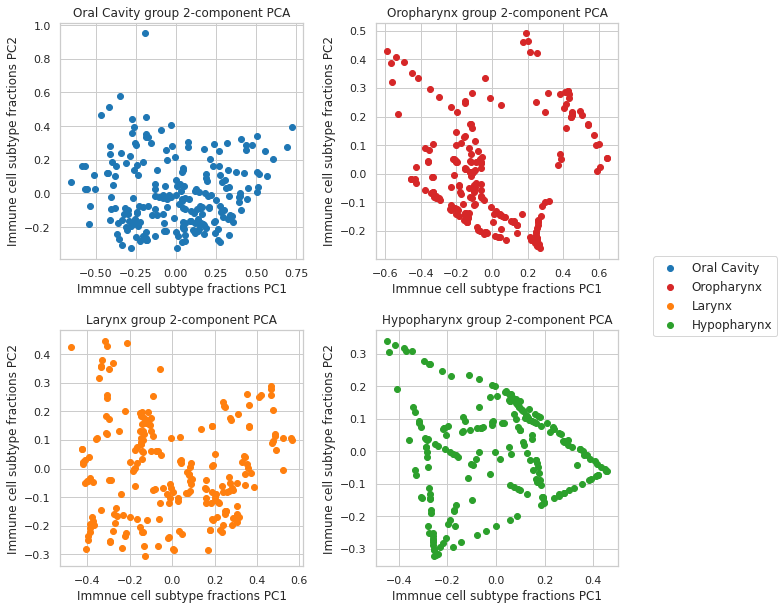

In [153]:
# Decon with immune subtypes
fig, ax = plt.subplots(2,2,figsize=(10,10))
pic = 0
dict_color_sites = {'Oral Cavity':'tab:blue','Oropharynx':'tab:red','Larynx':'tab:orange','Hypopharynx':'tab:green'}
for i in df_afterSMOTE['primary_site'].unique():
    df_mat_site = df_afterSMOTE[df_afterSMOTE['primary_site']==i].drop(['primary_site'],axis=1)
    pca = PCA(n_components=2)
    pca.fit(df_mat_site)
    print(pca.explained_variance_ratio_)
    axi = ax.flatten()[pic]
    axi.scatter(pca.transform(df_mat_site)[:,0],pca.transform(df_mat_site)[:,1],c=dict_color_sites[i],label=i)
    axi.set_xlabel("Immnue cell subtype fractions PC1")
    axi.set_ylabel("Immune cell subtype fractions PC2")
    axi.set_title(i+" group 2-component PCA")
    pic+=1
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.legend(loc='center left', bbox_to_anchor=(0.94, 0.5),fontsize=12)

###	HPV-positive versus HPV-negative oropharynx tumors (no other anatomical sites here)
> list of Oropharynx samples identified

In [82]:
df_oro = df_merged_relative[df_merged_relative['primary_site']=='Oropharynx']

NameError: name 'df_merged_relative' is not defined

In [78]:
df_oro['hpv_status'].value_counts()

Positive    46
Negative    23
Name: hpv_status, dtype: int64

In [79]:
df_oro_melt = pd.melt(df_oro,id_vars='hpv_status',value_vars=df_oro.columns[:10].tolist())
# df_oro_melt

Text(0, 0.5, 'Cell type fractions')

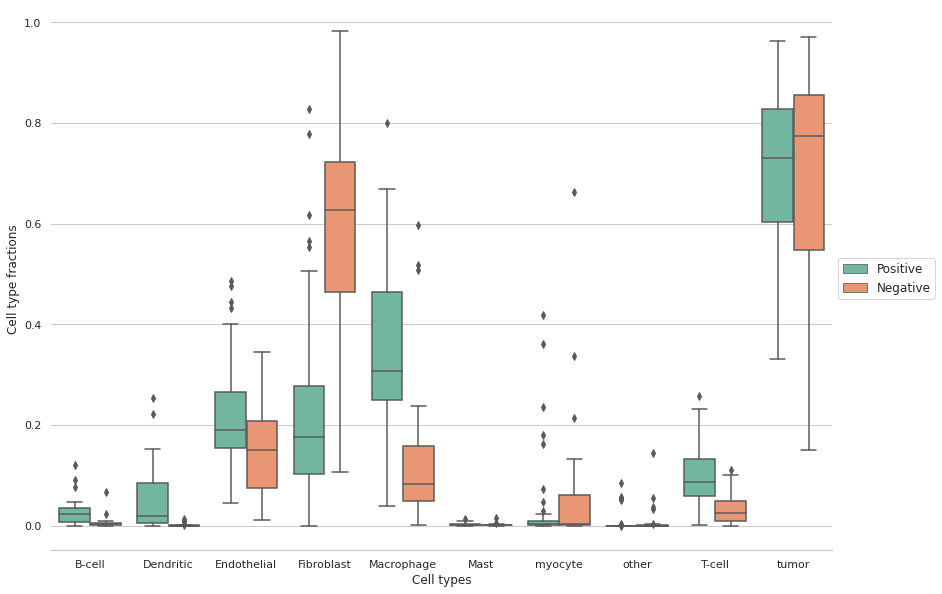

In [80]:
plt.subplots(figsize=(14,10))
sns.boxplot(x='variable',y='value',hue='hpv_status',data=df_oro_melt,palette="Set2")
sns.despine(left=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=12)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

In [81]:
# try oversampling HPV status, prove SMOTE does not amplify or cause change of pattern
## Vis Methods below need resampling!
# SMOTE upsample CNA silent group

sm = imblearn.over_sampling.SMOTE()
list_col = df_oro.columns[:10].tolist()

X_train, y_train = sm.fit_resample(df_oro.loc[:,list_col].to_numpy(),df_oro['hpv_status'])
print('Resampled dataset shape %s' % len(y_train))
print(y_train.value_counts())

Resampled dataset shape 92
Positive    46
Negative    46
Name: hpv_status, dtype: int64


In [82]:
df_afterSMOTE_hpv_oro = pd.DataFrame(X_train,columns=list_col)
df_afterSMOTE_hpv_oro['hpv_status'] = y_train
df_afterSMOTE_hpv_oro_melt = pd.melt(df_afterSMOTE_hpv_oro,id_vars='hpv_status',value_vars=df_afterSMOTE_hpv_oro.columns[:10].tolist())
# df_afterSMOTE_melt_site

Text(0, 0.5, 'Cell type fractions')

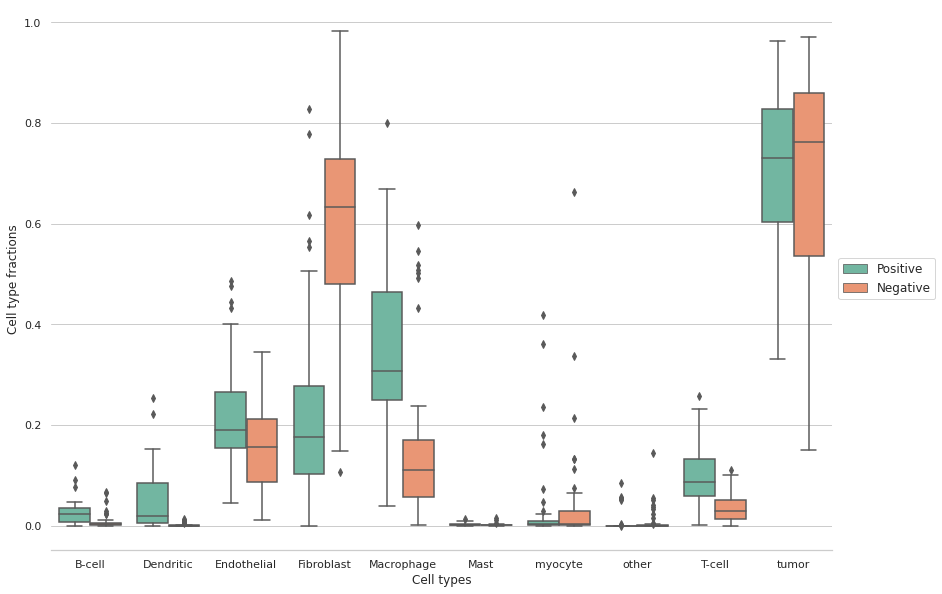

In [83]:
plt.subplots(figsize=(14,10))
sns.boxplot(x='variable',y='value',hue='hpv_status',data=df_afterSMOTE_hpv_oro_melt,palette="Set2")
sns.despine(left=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=12)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

### Decon result with immune subtypes

In [ ]:
# Immune cells only
df_merged_HPVneg_subtypes_immune_relative = df_merged_HPVneg_subtypes.copy()[['B-cells','CD14-cells','CD8-cells','Macrophage','NK-cells','pDC-cells','Mast','Tconv-cell','Treg-cells','fga','FGA_status','sample_match','primary_site','hpv_status']]
df_merged_HPVneg_subtypes_immune_relative.iloc[:,:9] = df_merged_HPVneg_subtypes_immune_relative.iloc[:,:9].div(df_merged_HPVneg_subtypes_immune_relative.iloc[:,:9].sum(axis=1),axis=0)
# df_merged_HPVneg_subtypes_immune_relative

In [38]:
df_oro_subtypes = df_merged_subtypes_nonrelative[df_merged_subtypes_nonrelative['primary_site']=='Oropharynx'][['B-cells','CD14-cells','CD8-cells','Macrophage','NK-cells','pDC-cells','Mast','Tconv-cell','Treg-cells','fga','FGA_status','sample_match','primary_site','hpv_status']]
df_oro_subtypes.iloc[:,:9] = df_oro_subtypes.iloc[:,:9].div(df_oro_subtypes.iloc[:,:9].sum(axis=1),axis=0)
df_oro_subtypes['hpv_status'].value_counts()

Positive    46
Negative    23
Name: hpv_status, dtype: int64

Text(0, 0.5, 'Cell type fractions')

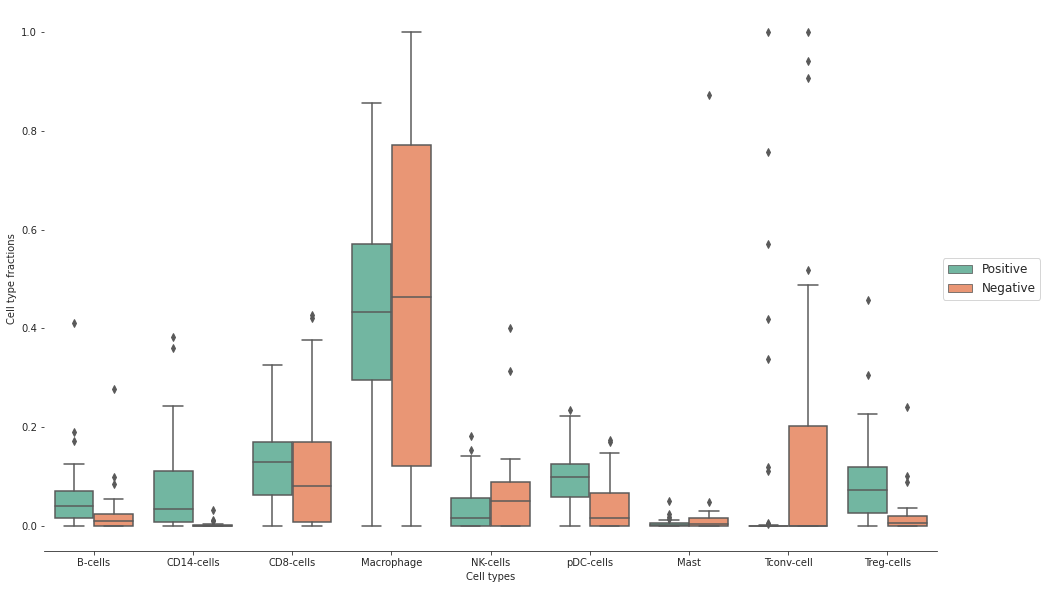

In [40]:
df_oro_subtypes_melt = pd.melt(df_oro_subtypes,id_vars='hpv_status',value_vars=df_oro_subtypes.columns[:9].tolist())

plt.subplots(figsize=(16,10))
sns.boxplot(x='variable',y='value',hue='hpv_status',data=df_oro_subtypes_melt,palette="Set2")
sns.despine(left=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=12)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

In [160]:
# try oversampling HPV status, prove SMOTE does not amplify or cause change of pattern
## Vis Methods below need resampling!
# SMOTE upsample CNA silent group

sm = imblearn.over_sampling.SMOTE()
list_col = df_oro_subtypes.columns[:12].tolist()

X_train, y_train = sm.fit_resample(df_oro_subtypes.loc[:,list_col].to_numpy(),df_oro_subtypes['hpv_status'])
print('Resampled dataset shape %s' % len(y_train))
print(y_train.value_counts())

Resampled dataset shape 92
Positive    46
Negative    46
Name: hpv_status, dtype: int64


In [161]:
df_afterSMOTE_hpv_oro_subtypes = pd.DataFrame(X_train,columns=list_col)
df_afterSMOTE_hpv_oro_subtypes['hpv_status'] = y_train
df_afterSMOTE_hpv_oro_subtypes_melt = pd.melt(df_afterSMOTE_hpv_oro_subtypes,id_vars='hpv_status',value_vars=df_afterSMOTE_hpv_oro_subtypes.columns[:12].tolist())
# df_afterSMOTE_hpv_oro_subtypes_melt

Text(0, 0.5, 'Cell type fractions')

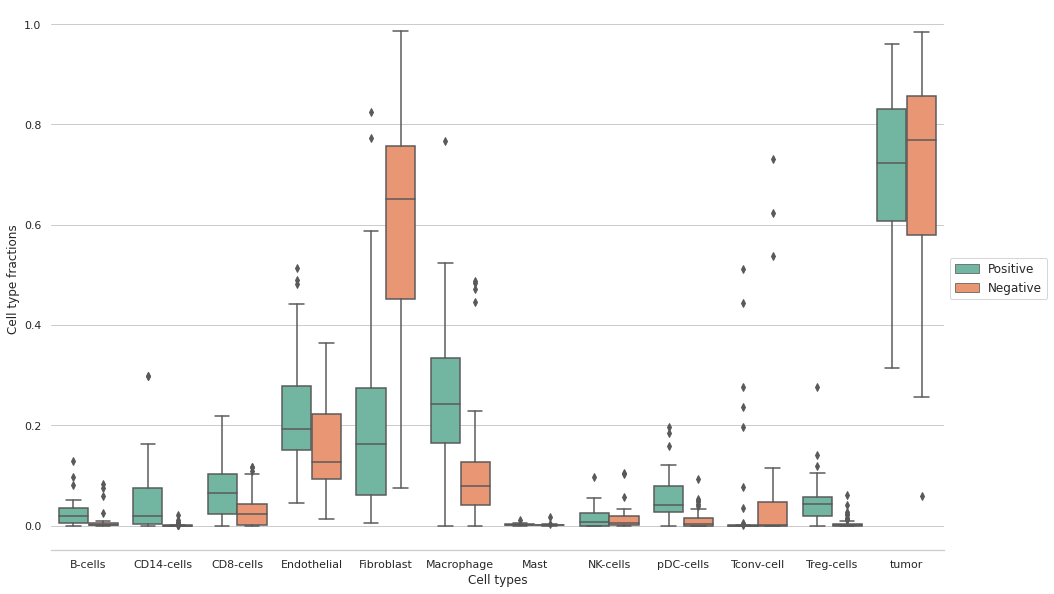

In [162]:
plt.subplots(figsize=(16,10))
sns.boxplot(x='variable',y='value',hue='hpv_status',data=df_afterSMOTE_hpv_oro_subtypes_melt,palette="Set2")
sns.despine(left=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=12)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")